# Open System Data Analysis
### Useful Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from matplotlib import cm
from scipy import signal
from tqdm import tqdm
import os

### Useful Functions

In [19]:
def getParams(filename):
    """
    getParams obtains T1 and T2 decoherence times from a given file
    
    Parameters
    ----------
    filename      Filename to get data
            
    Returns
    -------
    T1vec         Array of T1 times for all qubits
    T2vec         Array of T2 times for all qubits
    
    """
    
    tRead = np.zeros(5)
    T1vec = np.zeros(5)
    T2vec = np.zeros(5)
    
    with open(filename) as file_in:
        Qn = 0
        calA = np.zeros((5,2,2))
        lines = []
        for line in file_in:
            lines.append(line)

        iData = len(lines)

        for i in range(len(lines)):
            if(len(lines[i]) > 7):
                if(lines[i].split(',')[5] == 'T1'):
                    T1vec[Qn] = float(lines[i].split(',')[6])
                if(lines[i].split(',')[5] == 'T2'):
                    T2vec[Qn] = float(lines[i].split(',')[6])
                if(lines[i].split(',')[5] == 'readout_length'):
                    tRead[Qn] = float(lines[i].split(',')[6])
                    Qn = Qn + 1

            if(lines[i] == 't,P0q0,P0q1,P0q2,P0q3,P0q4,P0q0c,P0q1c,P0q2c,P0q3c,P0q4c,tR\n'):
                iData = i
                P = np.zeros((len(lines)-iData-1, 5))
                tR = np.zeros(len(lines)-iData-1)
            if(i > iData):
                templine = lines[i][:-2].split(',')
                templine = list(map(float, templine))
                
                for j in range(5):
                        P[i - iData - 1, j] = templine[j+6]
                tR[i - iData - 1] = templine[11]
                
    return [T1vec, T2vec]
    
def pulse(t, a, b):
    return np.heaviside(t - a, 1) - np.heaviside(t - b, 1)

def H0_coeff(t, args):
    return pulse(t, 0, args['Tf'])

def H1_coeff(t, args):
    return t

def Hrel(T1, T2):
    """
    L1 computes the relaxation Lindblad operator
    
    Parameters
    ----------
    T1            Qubit relaxation time
    T2            Effective dephasing time
            
    Returns
    -------
    L1            Relaxation Lindblad operator
    
    """
    
    Gamma = 1 / T1
    L1 = np.sqrt(Gamma) * (1 / 2) * (1j * sigmay() + sigmax())
    
    return L1

def L2(T1, T2):
    """
    L2 computes the dephasing Lindblad operator
    
    Parameters
    ----------
    T1            Qubit relaxation time
    T2            Effective dephasing time
            
    Returns
    -------
    L2            Dephasing Lindblad operator
    
    """
    
    gamma = complex(1 / T2 - 1 / (2 * T1))
    L2 = np.sqrt(gamma) * sigmaz()

    return L2

In [20]:
Dlist1 = np.linspace(2,40,20)

invDlist2 = np.linspace(0.5, 2, 16)
Dlist2 = 1/invDlist2
Dlist2 = np.around(Dlist2,2)

Dlist = np.concatenate((Dlist1, Dlist2))
Dlist = np.unique(np.sort(Dlist))

taList = 1 / Dlist

\Delta disponibles:


array([ 0.5 ,  0.53,  0.56,  0.59,  0.62,  0.67,  0.71,  0.77,  0.83,
        0.91,  1.  ,  1.11,  1.25,  1.43,  1.67,  2.  ,  4.  ,  6.  ,
        8.  , 10.  , 12.  , 14.  , 16.  , 18.  , 20.  , 22.  , 24.  ,
       26.  , 28.  , 30.  , 32.  , 34.  , 36.  , 38.  , 40.  ])

In [21]:
Nlist = np.array([50, 100, 150, 200])
markerList = np.array(['o', 's', '^', 'D', 'v'])
cmp = cm.get_cmap('brg', 5)

def file2Matrix(filename):
    with open(filename) as file_in:
        lines = []
        for line in file_in:
            lines.append(line)
    
    dataStart = False
    iDataStart = len(lines)
    for i in range(len(lines)):
        if(lines[i] == 't,P0q0,P0q1,P0q2,P0q3,P0q4,P0q0c,P0q1c,P0q2c,P0q3c,P0q4c,tR\n'):
            dataStart = True
            iDataStart = i
            dataMatrix = np.zeros((len(lines[iDataStart+1:]), 12))
        elif(dataStart):
            tempLine = lines[i][:-2]
            tempLine = tempLine.split(',')
            tempLine = list(map(float, tempLine))
            dataMatrix[i - (iDataStart + 1), :] = tempLine
    return dataMatrix

def plotQubitsDeltaSep(backend, D, calibrated = False):
    fig, axs = plt.subplots(4,5, figsize=(16, 8))
    
    for i in range(len(axs)):
        for j in range(len(axs[0])):
            tail = backend+'_SH5000_N'+str(Nlist[i])+'_w1_D'+str(D)+'_calibrated.dat'
            filename = 'DataCal_13_07_NoReadout/' + tail
            if(tail in os.listdir('DataCal_13_07_NoReadout')):
                Data = file2Matrix(filename)
                t = Data[:,0]
                tR = Data[:, 11] / 1000

                if(calibrated):
                    P = Data[:,6:11]
                    fig.suptitle(r'$\omega_0 = $'+str(D)+'\n (ibmq_' + backend + ')', fontsize = 16)
                    # fig.suptitle(r'$\Delta = $' +str(D) , fontsize = 30)
                else:
                    P = Data[:,1:6]
                    fig.suptitle('Raw Results', fontsize = 30)

                if(i != 2):
                    axs[i,j].get_xaxis().set_visible(True)
                N = 50*(i+1)
                factConv = (t[-1] / N)/0.07111
                axs[i,j].scatter(t / factConv, P[:,j], s = 4, marker = markerList[j], color = np.array(cmp(j)))
                
                times = np.linspace(0, t[-1], 1000)
                

                
                [T1vec, T2vec] = getParams(filename)
                T1 = T1vec[j] * factConv
                T2 = T2vec[j] * factConv
                omega0 = 1
                psi0 = (-1 / np.sqrt(2)) * basis(2, 0) + (1 / np.sqrt(2)) * basis(2, 1) # AntiCrossing
                H0 = (1 / 2) * omega0 * sigmax() 
                H1 = (1 / 2) * D * sigmaz()
                H = [H0, [H1, H1_coeff]]
                
                result = mesolve(H, psi0, times, [L2(T1, T2), Hrel(T1, T2)], sigmaz())
                result2 = mesolve(H, psi0, times, [], sigmaz())

                Esz = result.expect[0]
                Esz2 = result2.expect[0]
                rho00 = (1.0 + Esz) / 2.0
                rho00_close = (1.0 + Esz2) / 2.0
                
                axs[i,j].plot(result.times / factConv, rho00, color = 'k', linestyle = 'solid', alpha = 0.6)
                # axs[i,j].plot(result2.times / factConv, rho00_close, color = 'r')
                axs[i,j].set_ylim((0, 0.8))
                axs[i,j].text(0, 0.7, r'$T_1 = $'+str(np.round(T1,2))+r'$\mu$ s', fontsize = 8)
                axs[i,j].text(0, 0.1, r'$T_2 = $'+str(np.round(T2,2))+r'$\mu$ s', fontsize = 8)
                if i == 0:
                    axs[i,j].set_title(r'Q'+str(j), fontsize = 16)
                if i == 3:
                    axs[i,j].set_xlabel(r'$t\>[\mu s]$', fontsize = 16)
                if j == 0:
                    axs[i,j].set_ylabel(r'$N_t = $'+str(50*(i+1)), fontsize = 16)
                
def plotOpen(backend, qbt, D, Nlist, calibrated = True):
    fig, axs = plt.subplots(1,4, figsize=(12, 8))
    
    ind = 0
    for N in Nlist:
        tail = backend+'_SH5000_N'+str(N)+'_w1_D'+str(D)+'_calibrated.dat'
        filename = 'DataCal_13_07_NoReadout/' + tail
        if(tail in os.listdir('DataCal_13_07_NoReadout')):
            Data = file2Matrix(filename)
            t = Data[:,0]
            tR = Data[:, 11] / 1000

            if(calibrated):
                P = Data[:,6:11]
                fig.suptitle(r'$\omega_0 = $' +str(D) , fontsize = 30)
            else:
                P = Data[:,1:6]
                # fig.suptitle('Raw Results', fontsize = 30)

            factConv = (t[-1] / N)/0.07111
            axs[ind].scatter(t / factConv, P[:,qbt], s = 4, label = r'$N = $'+str(N))

            times = np.linspace(0, t[-1], 2000)

            [T1vec, T2vec] = getParams(filename)
            T1 = T1vec[qbt] * factConv
            T2 = T2vec[qbt] * factConv
            omega0 = 1
            psi0 = (-1 / np.sqrt(2)) * basis(2, 0) + (1 / np.sqrt(2)) * basis(2, 1) # AntiCrossing
            H0 = (1 / 2) * omega0 * sigmax() 
            H1 = (1 / 2) * D * sigmaz()
            H = [H0, [H1, H1_coeff]]

            result = mesolve(H, psi0, times, [L2(T1, T2), Hrel(T1, T2)], sigmaz())
            result2 = mesolve(H, psi0, times, [], sigmaz())

            Esz = result.expect[0]
            Esz2 = result2.expect[0]
            rho00 = (1.0 + Esz) / 2.0
            rho00_close = (1.0 + Esz2) / 2.0

            axs[ind].plot(result.times / factConv, rho00, color = 'k', linestyle = 'dashed', alpha = 0.6)
            axs[ind].set_ylim((0, 0.8))
            axs[ind].set_xlabel(r'$t\>[\mu s]$')
            axs[ind].set_title(r'$N = $'+str(N))
            ind = ind + 1

<ipython-input-21-330d74db6eb2>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(4,5, figsize=(16, 8))


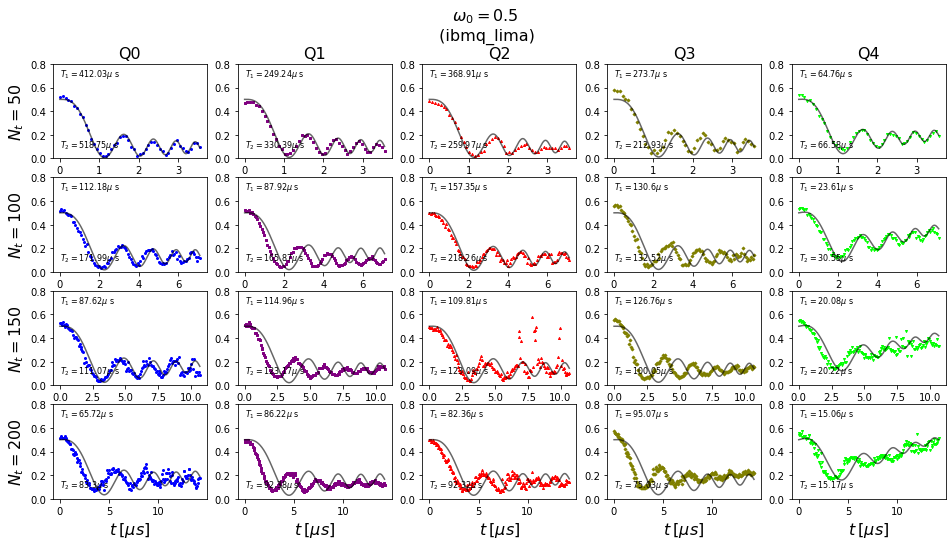

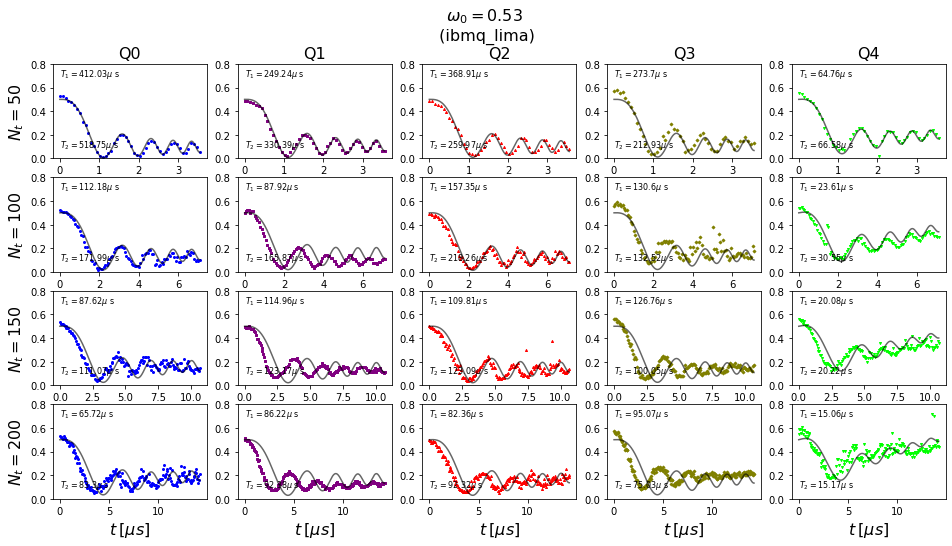

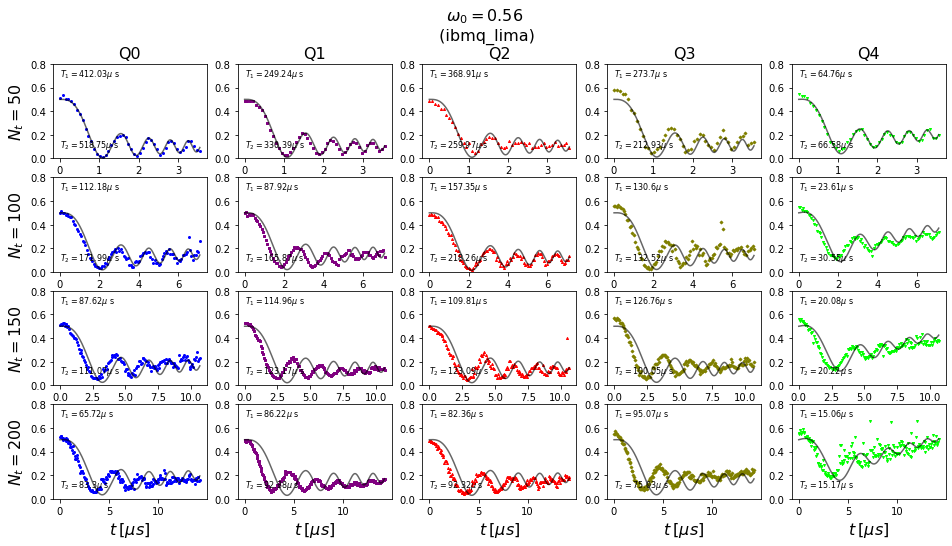

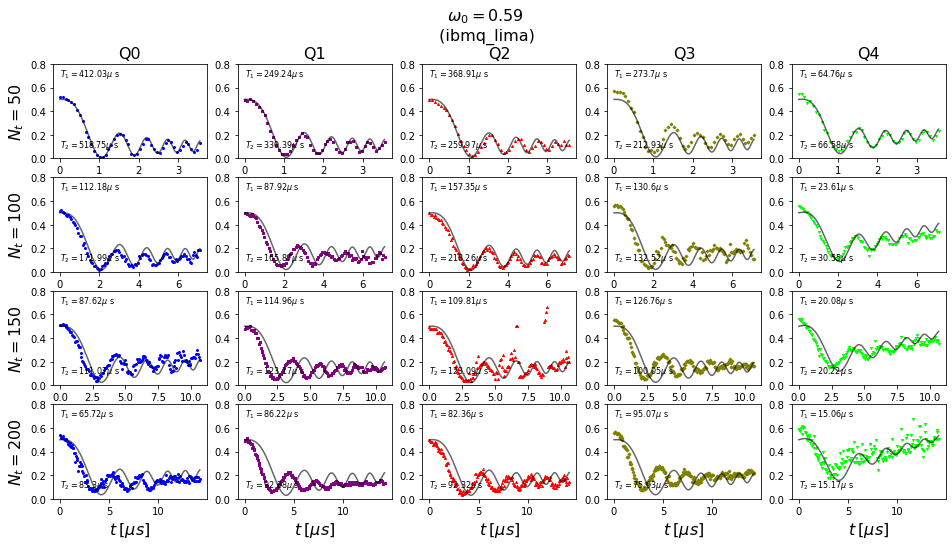

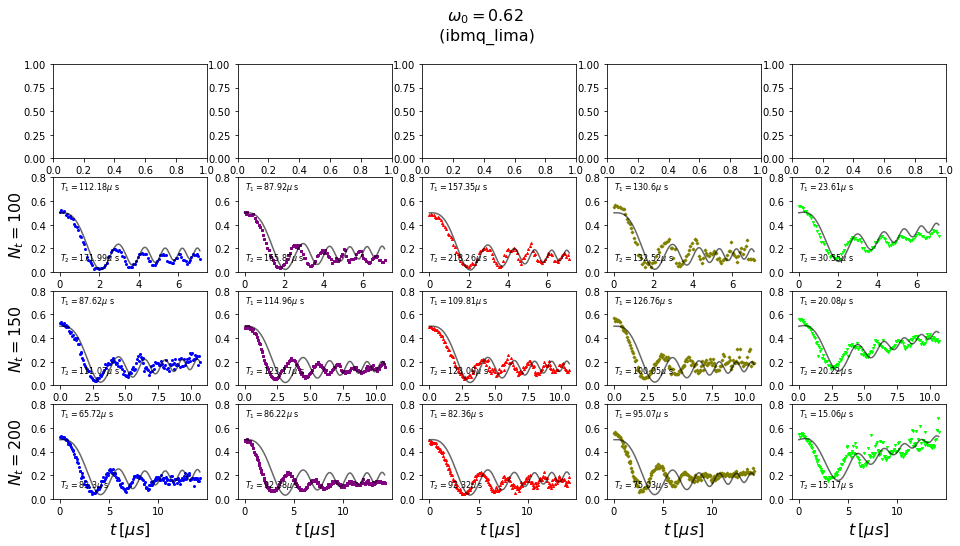

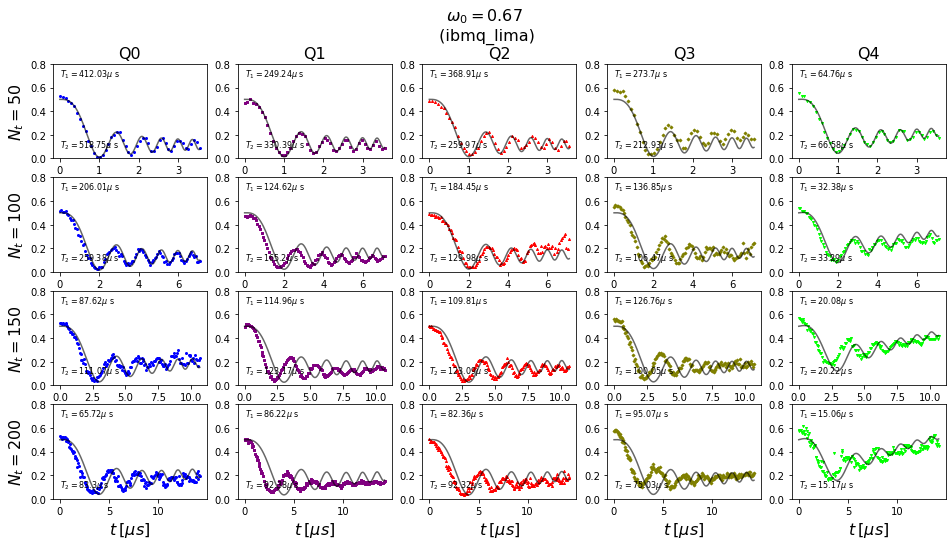

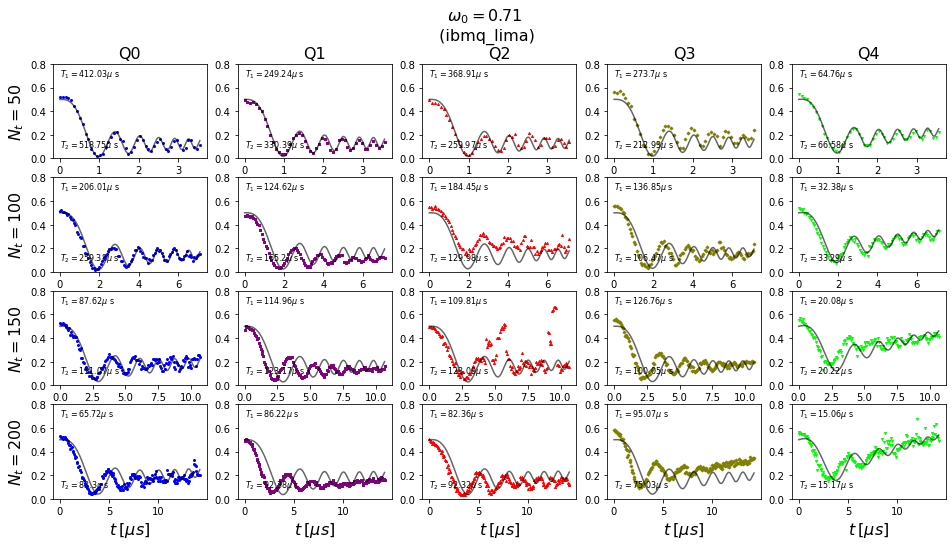

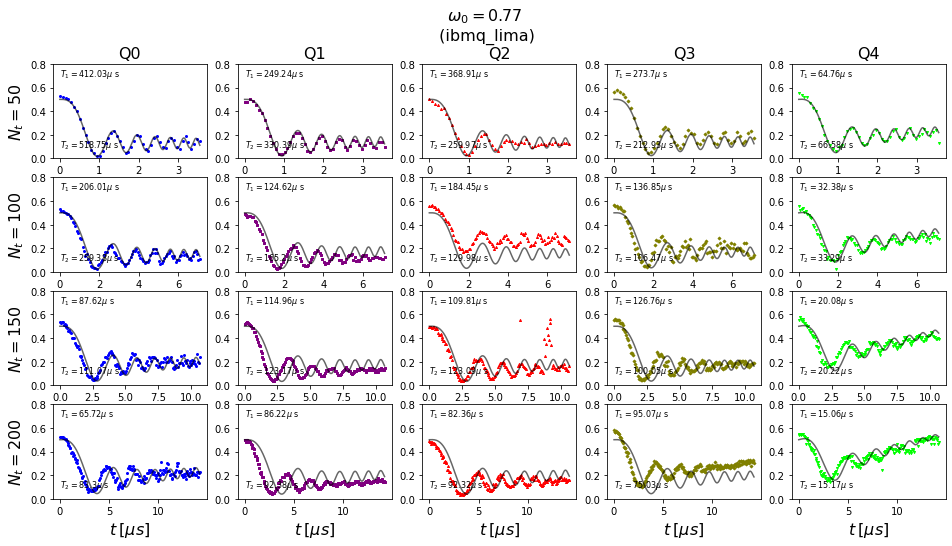

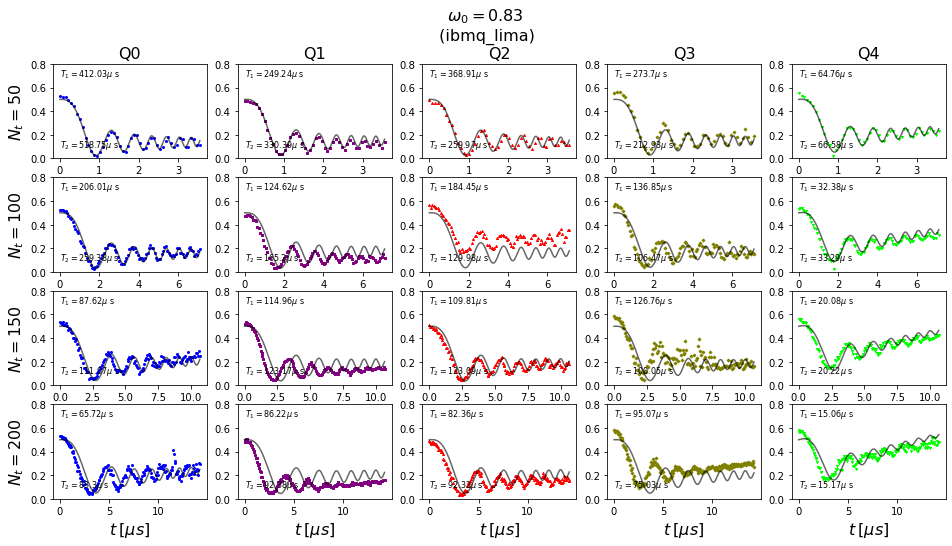

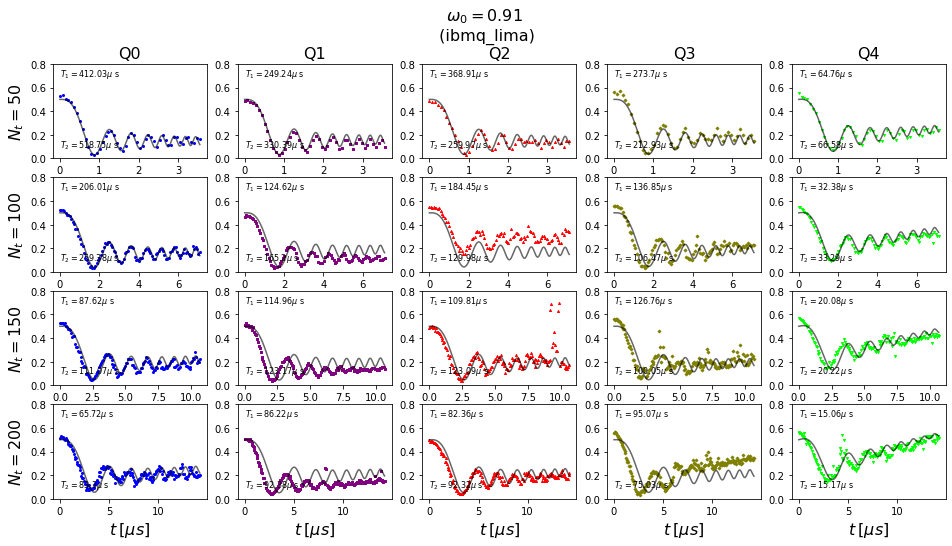

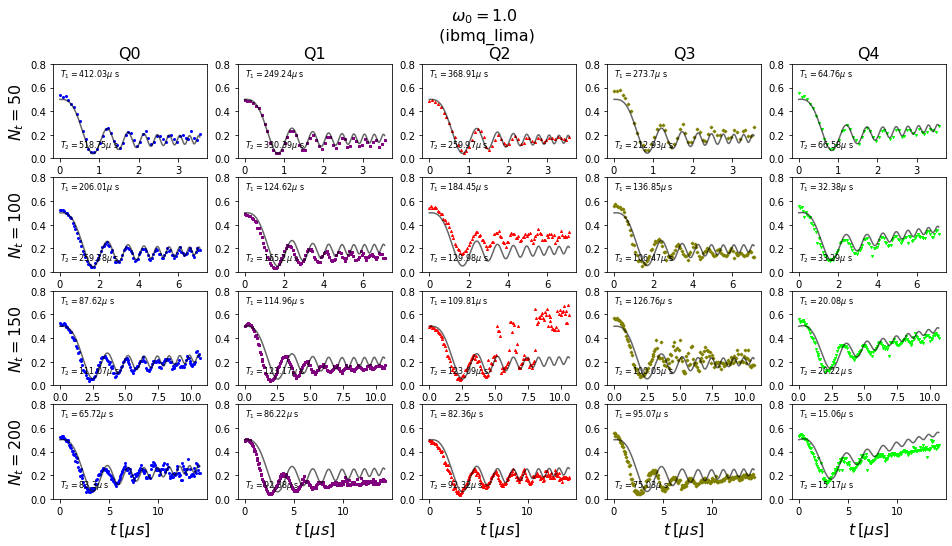

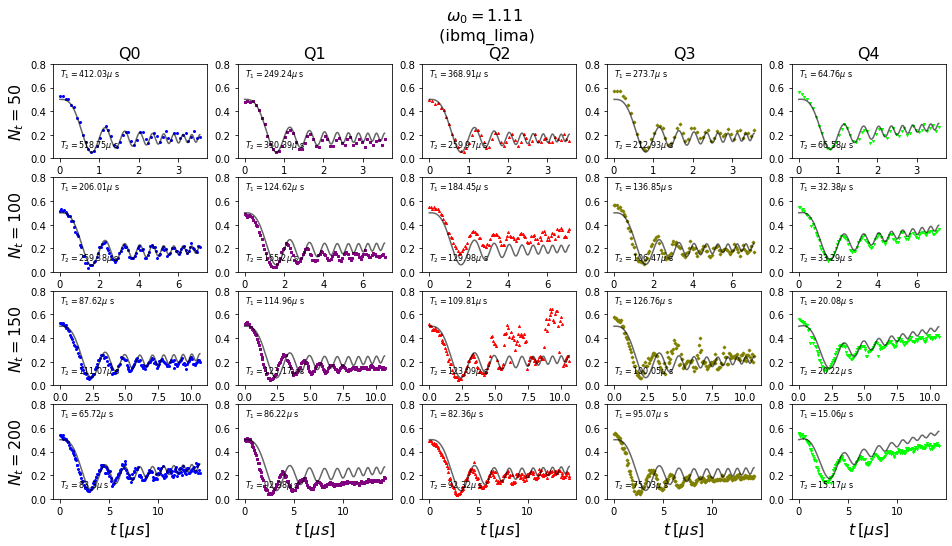

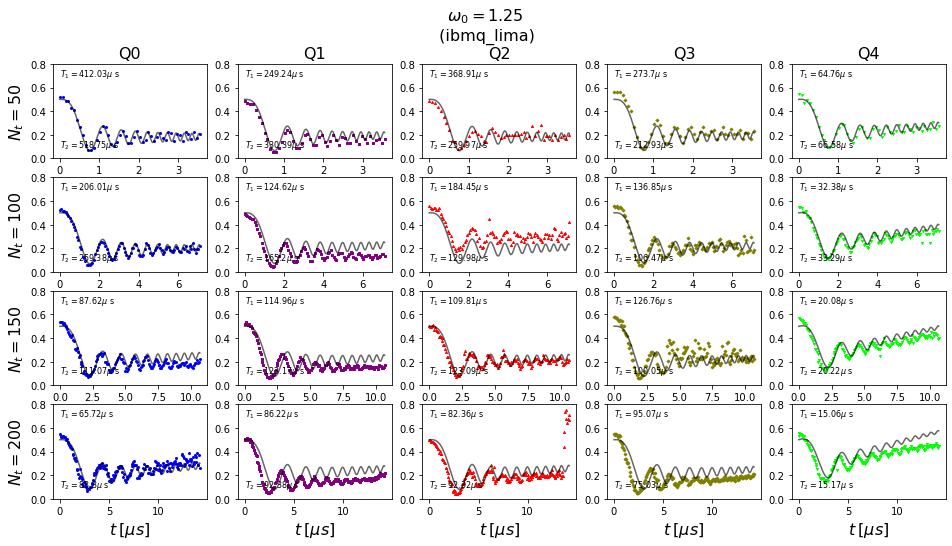

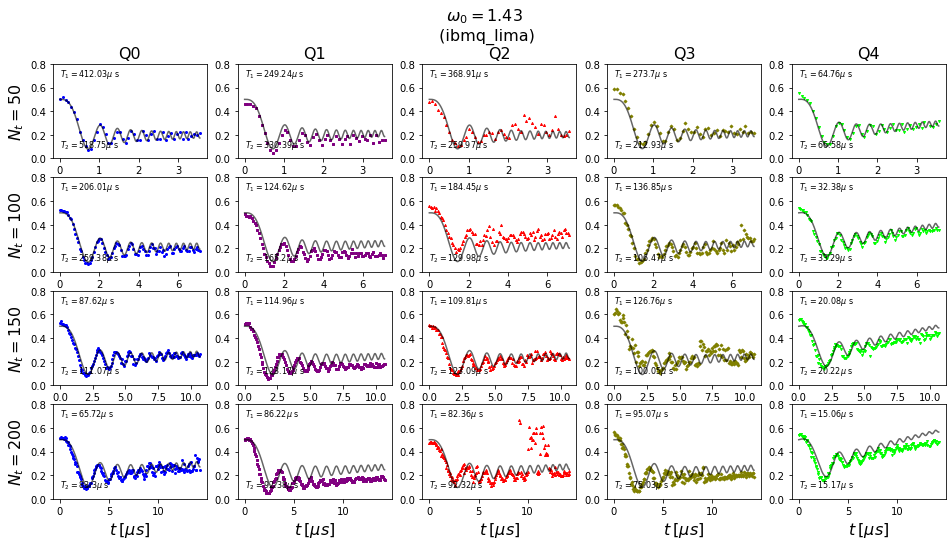

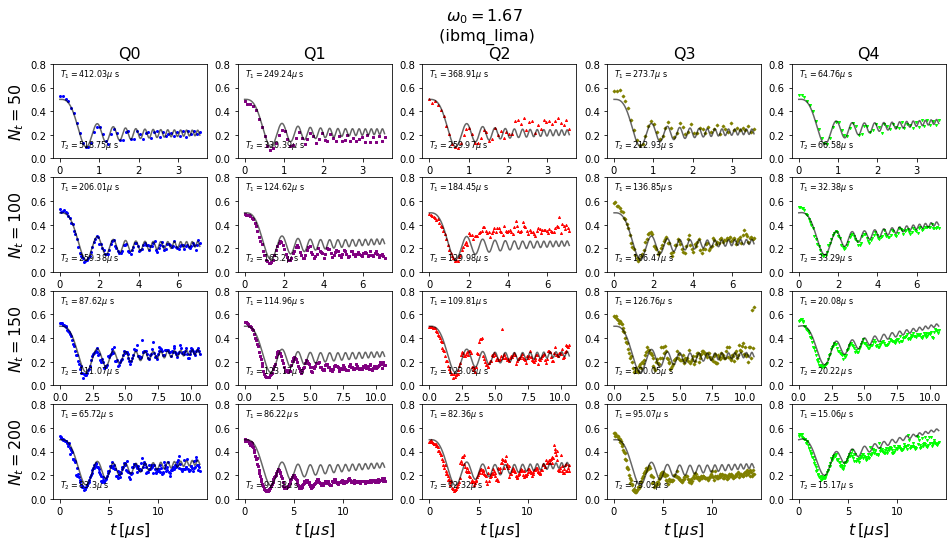

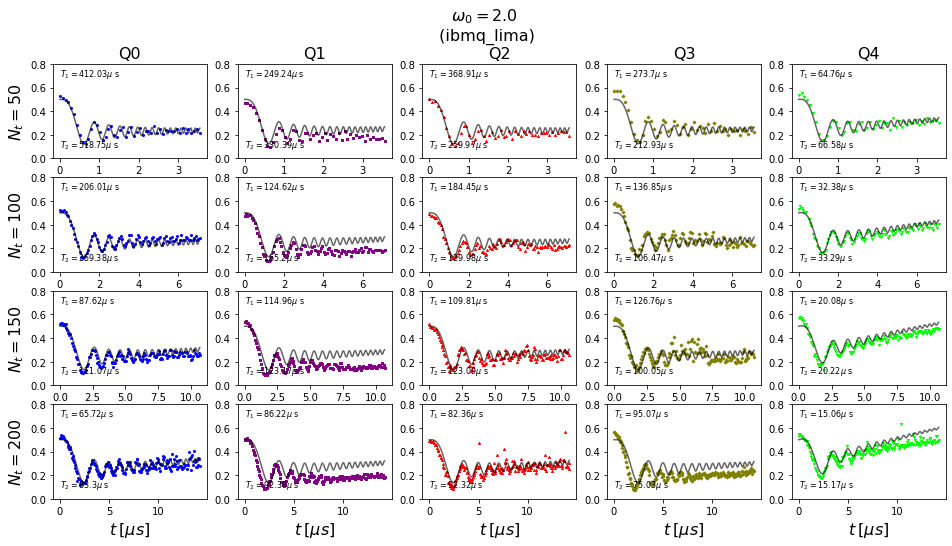

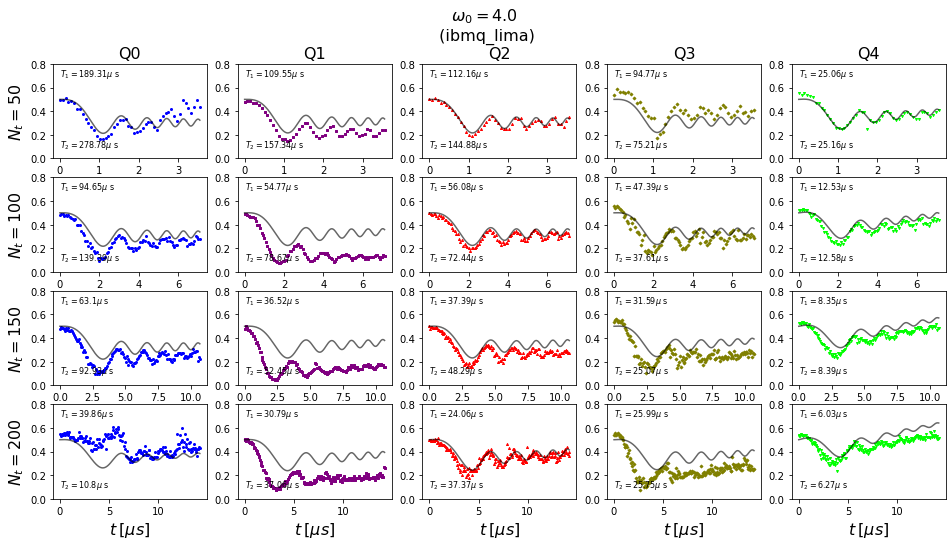

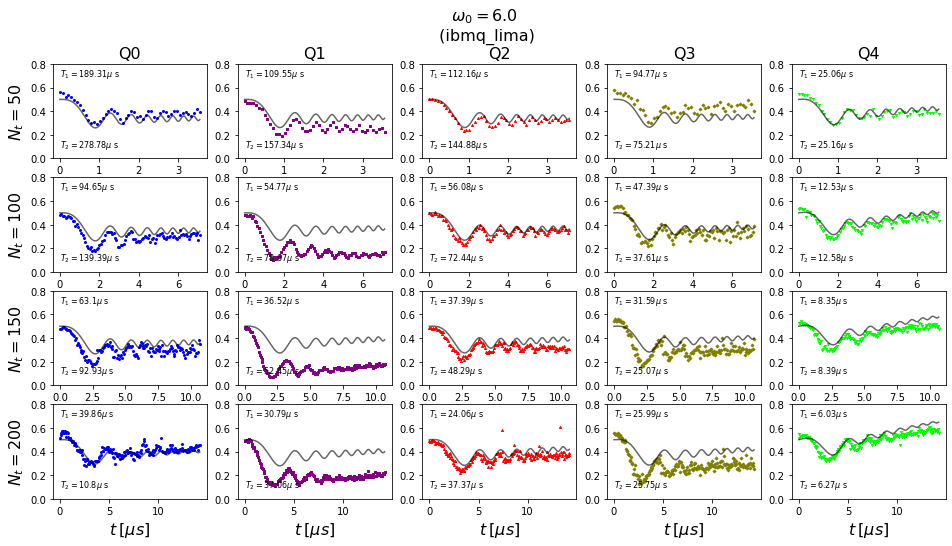

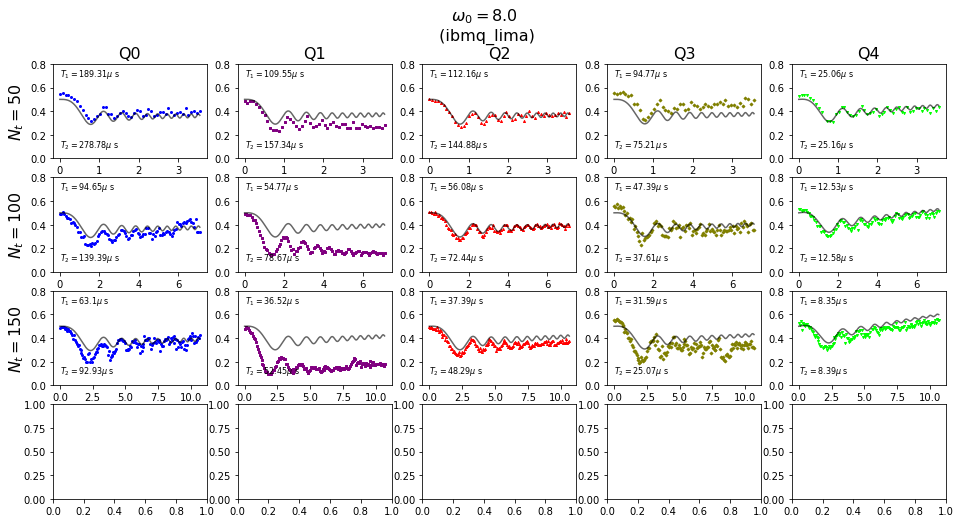

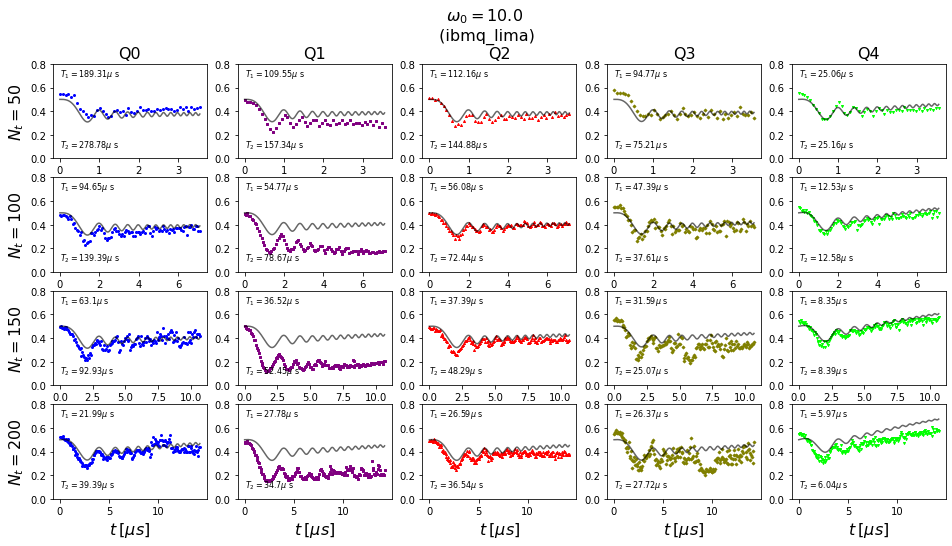

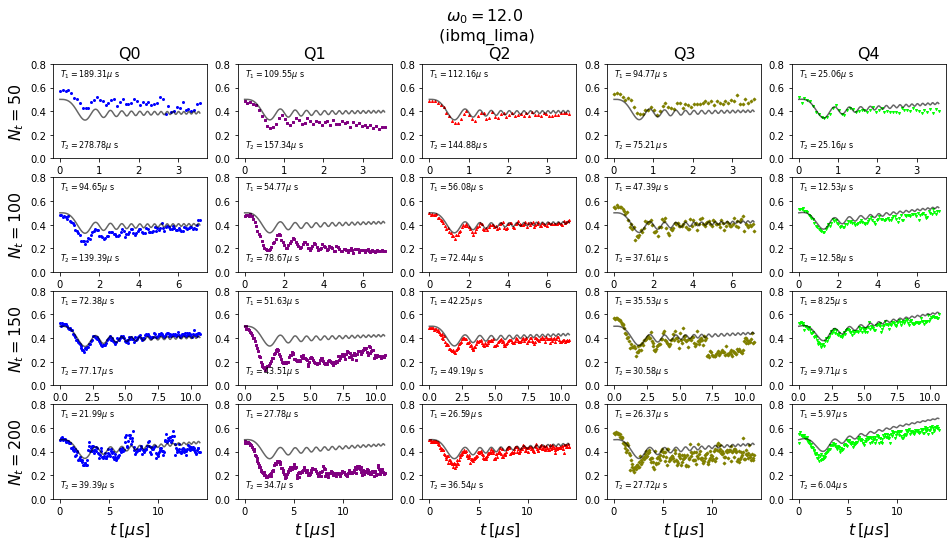

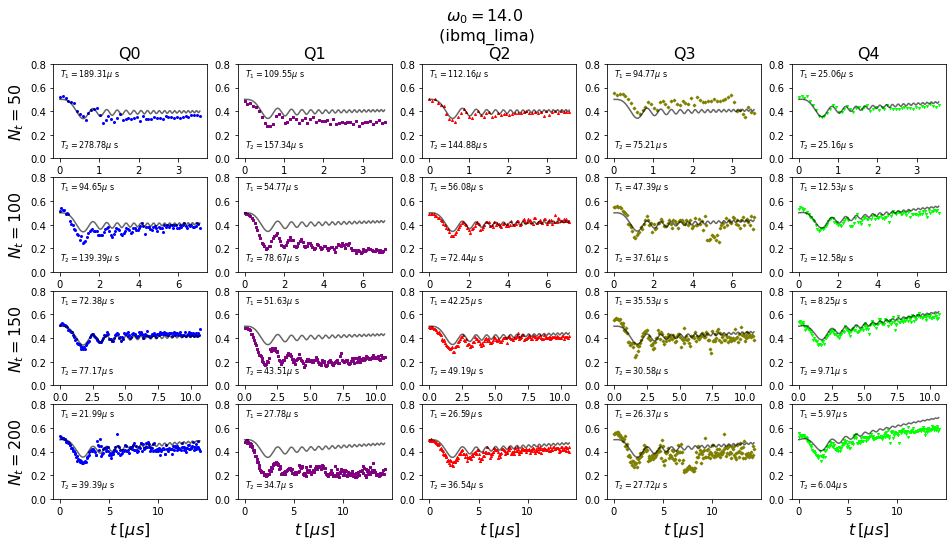

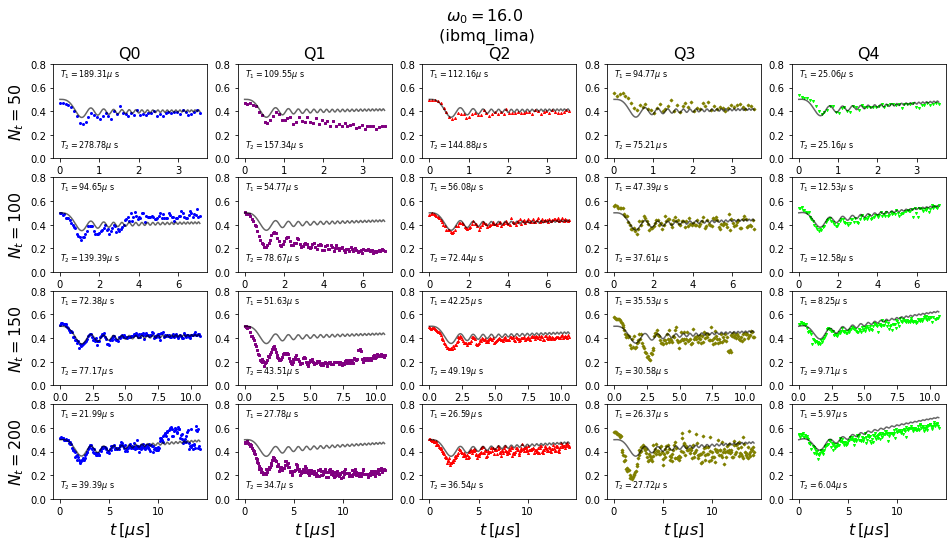

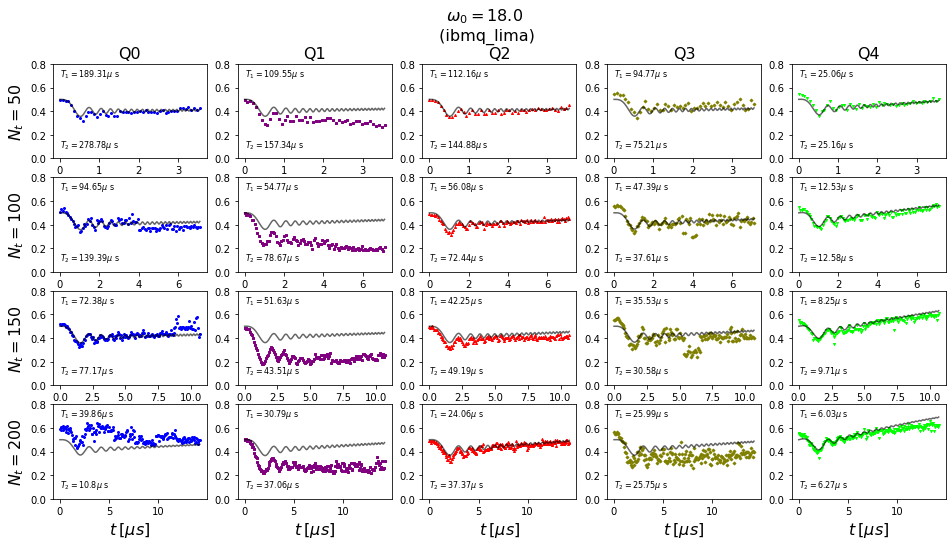

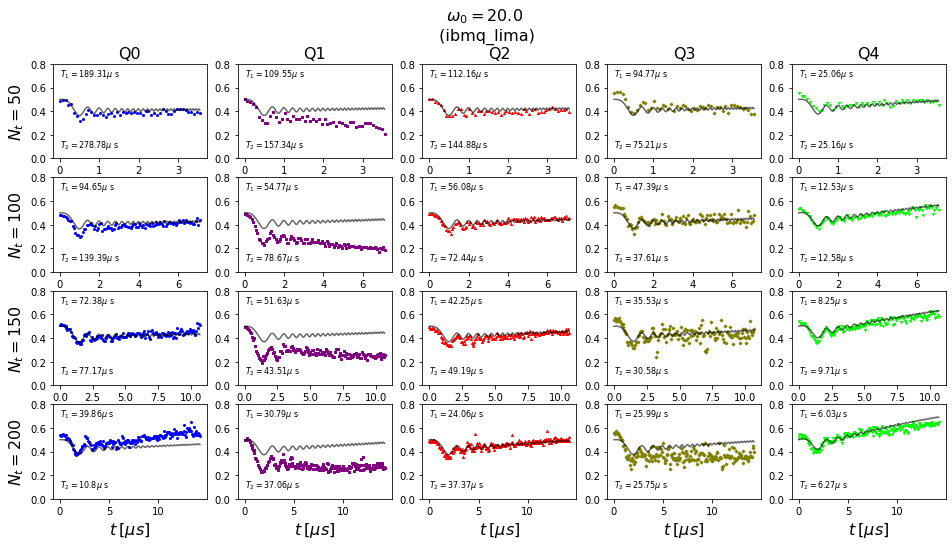

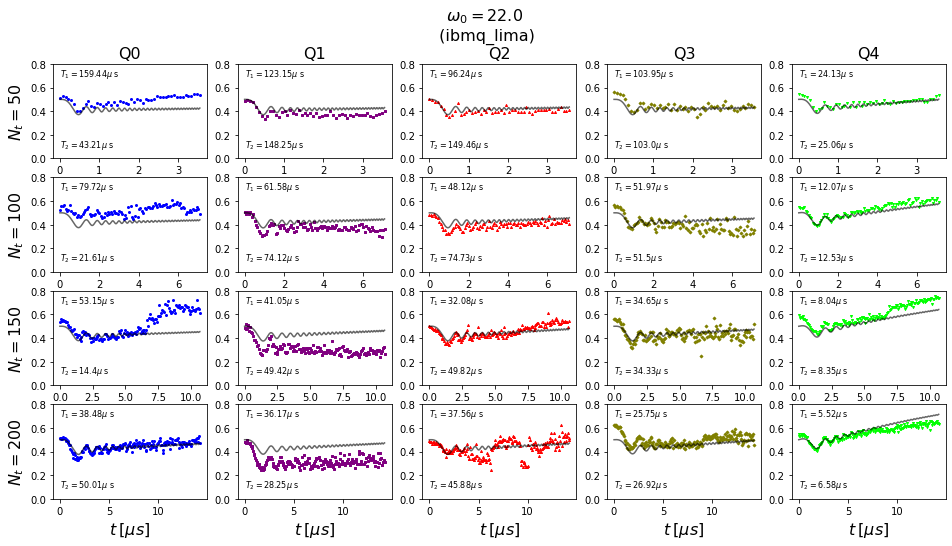

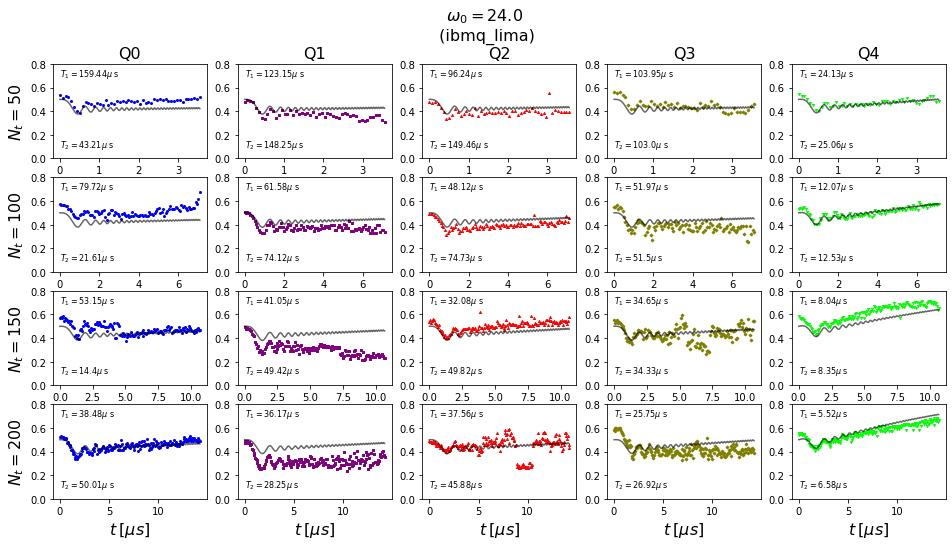

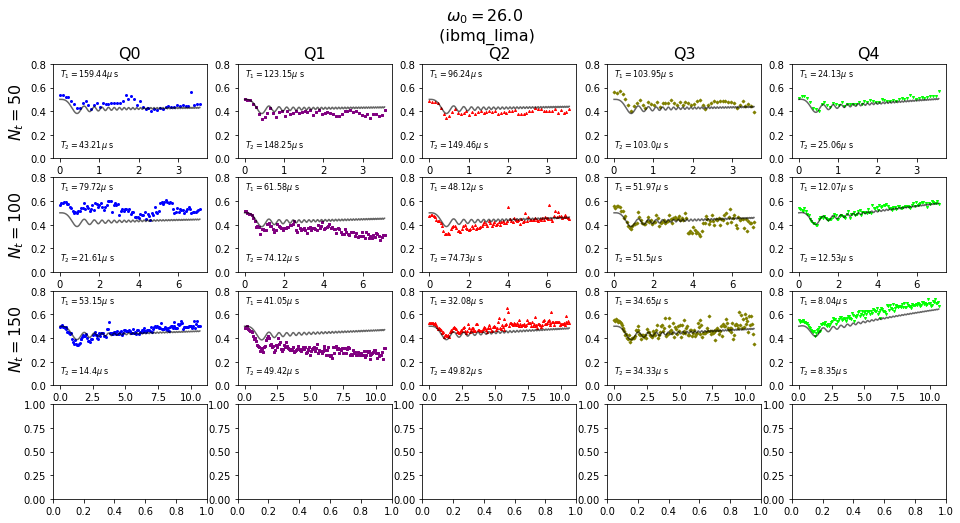

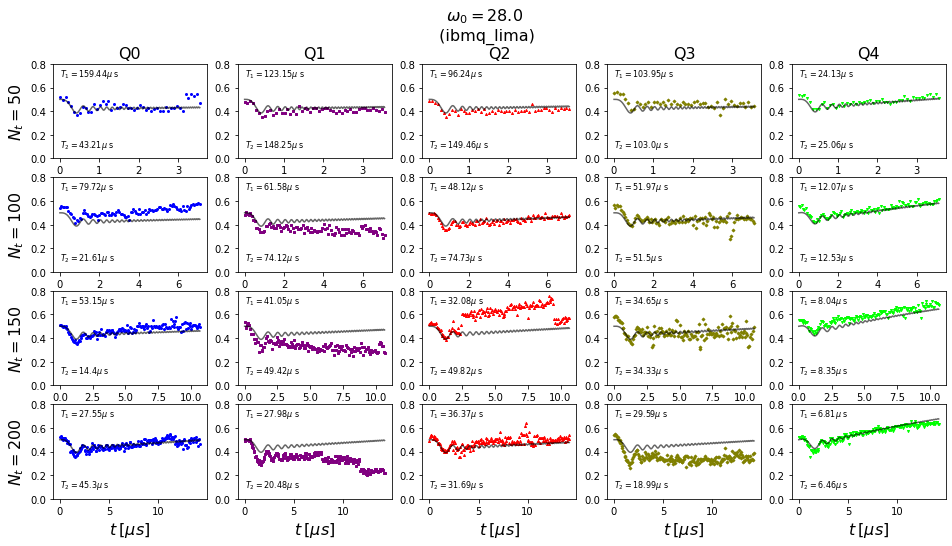

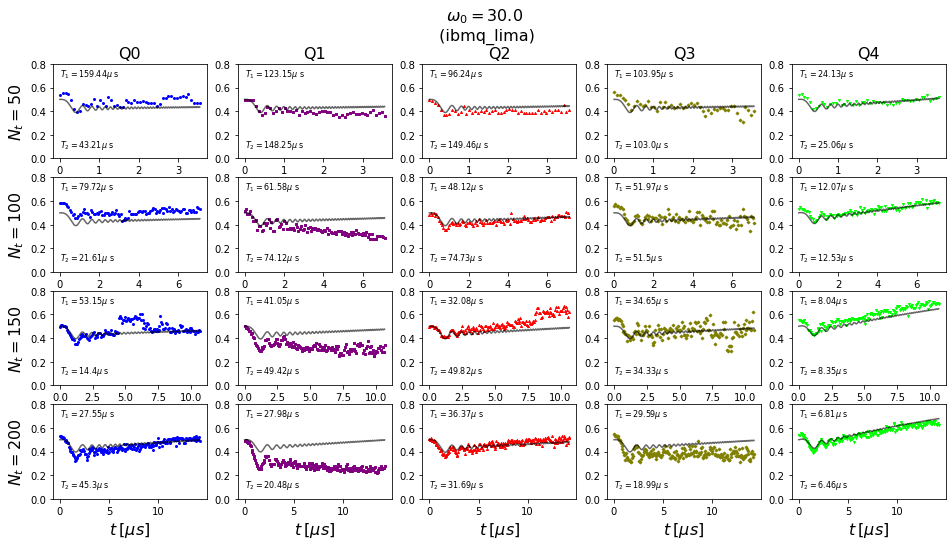

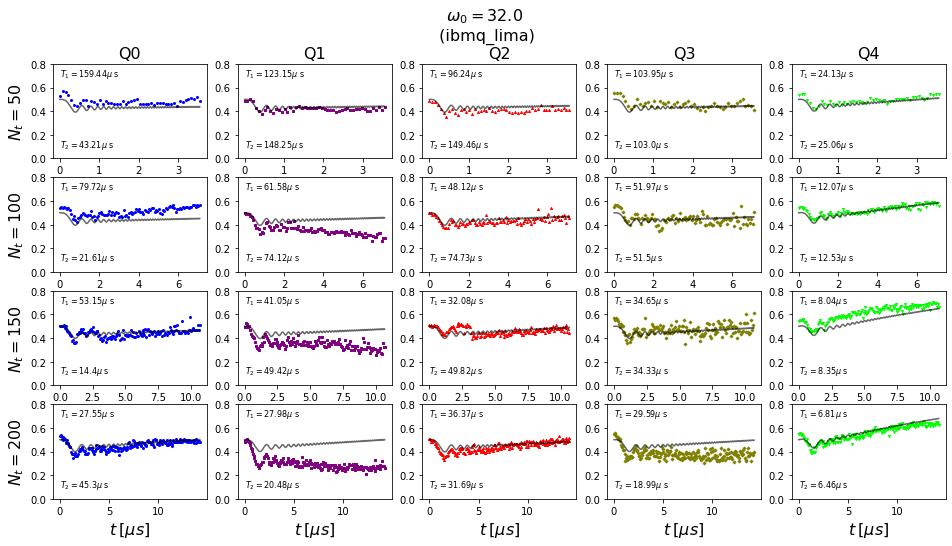

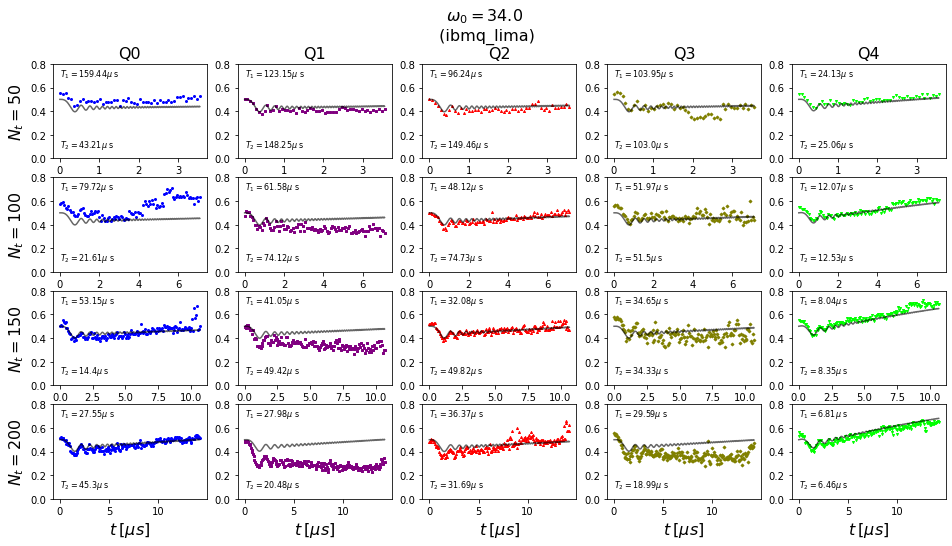

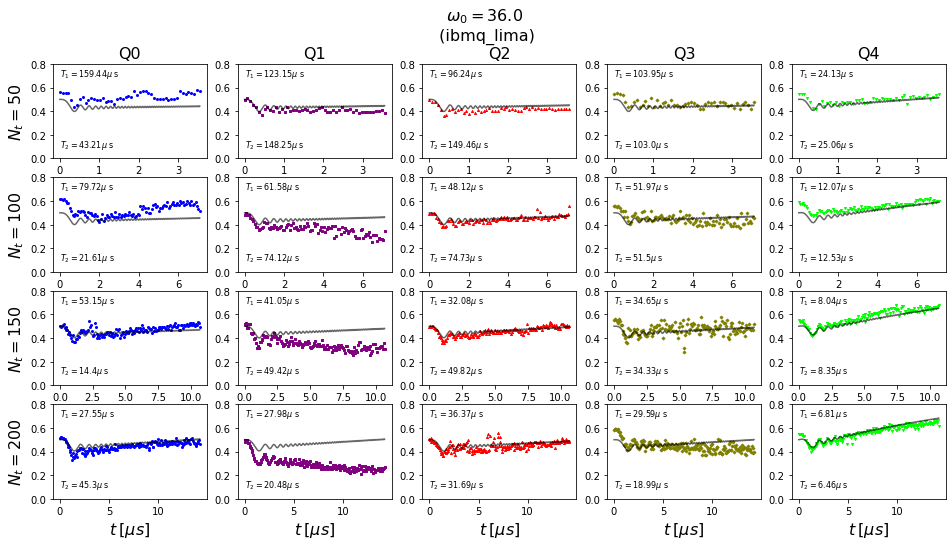

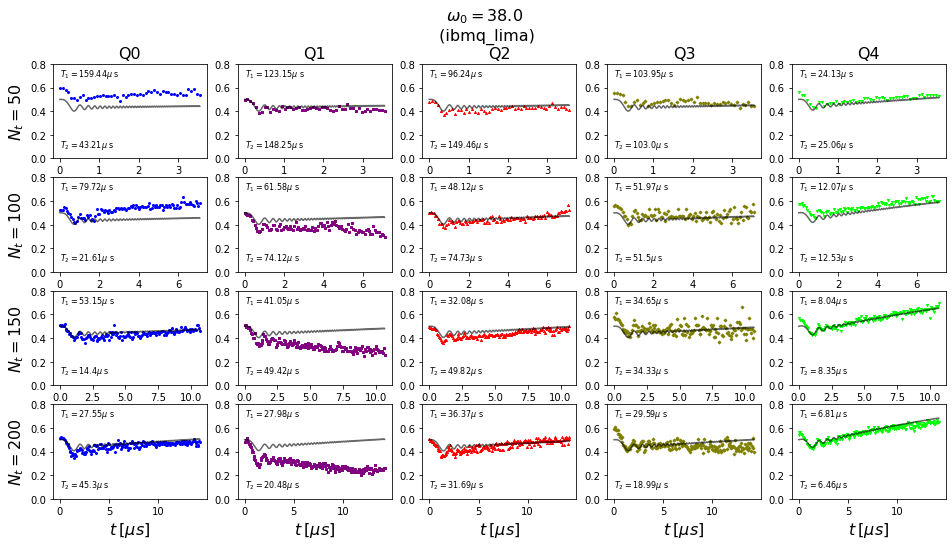

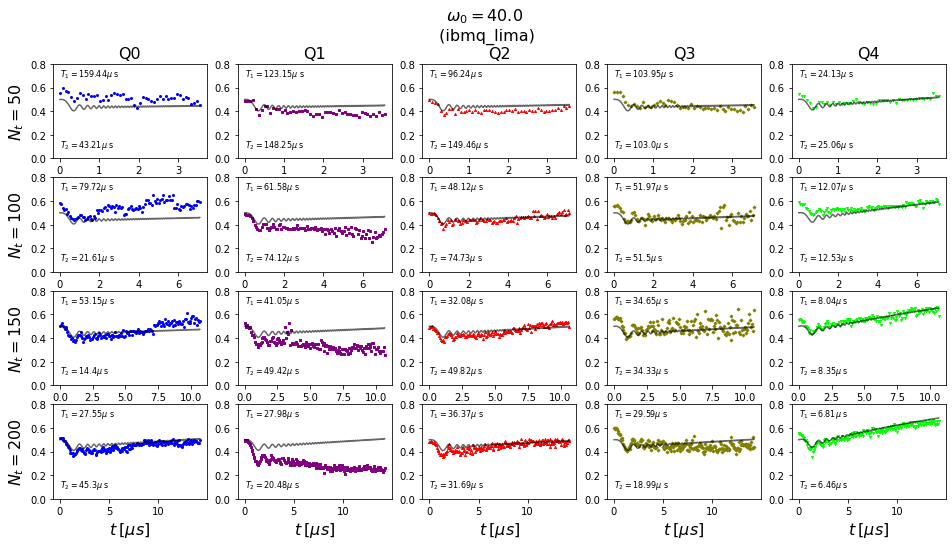

In [22]:
for D in Dlist:
    plotQubitsDeltaSep('lima', D, calibrated = True)

<ipython-input-21-330d74db6eb2>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(4,5, figsize=(16, 8))


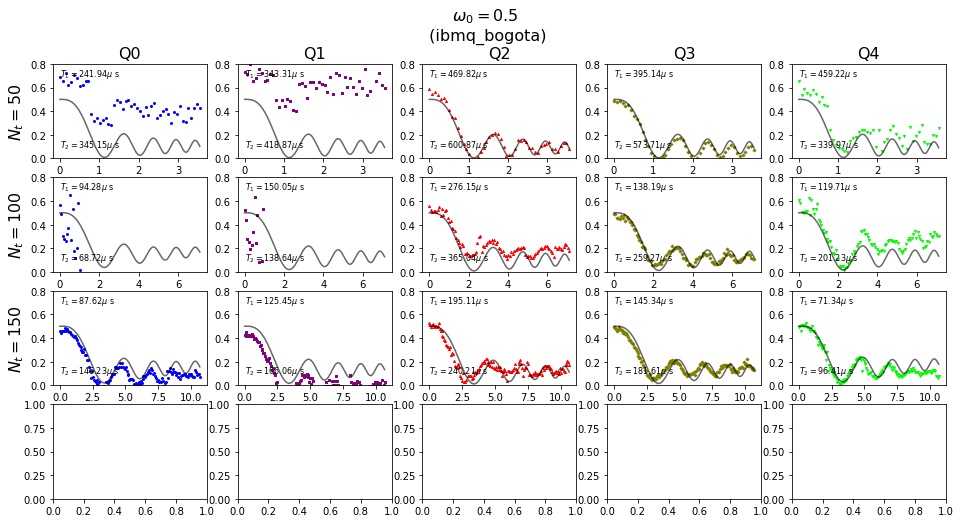

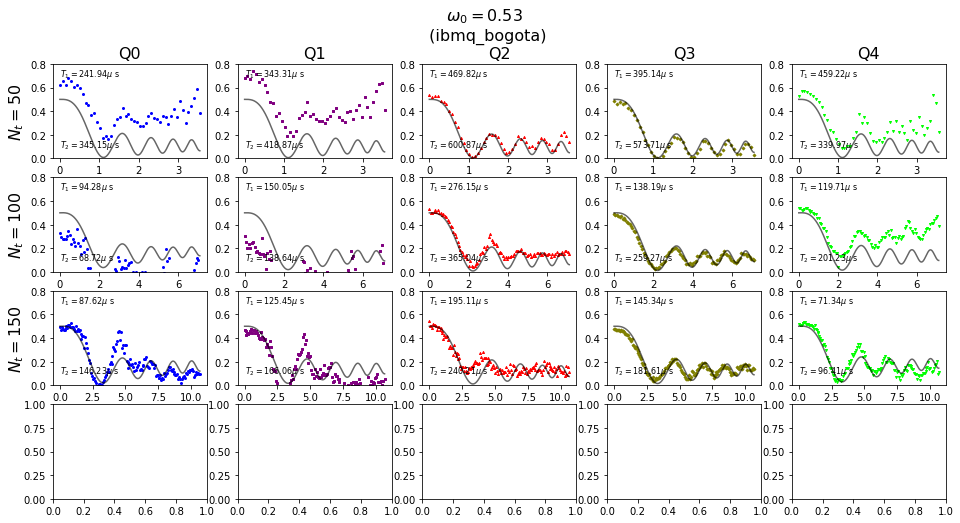

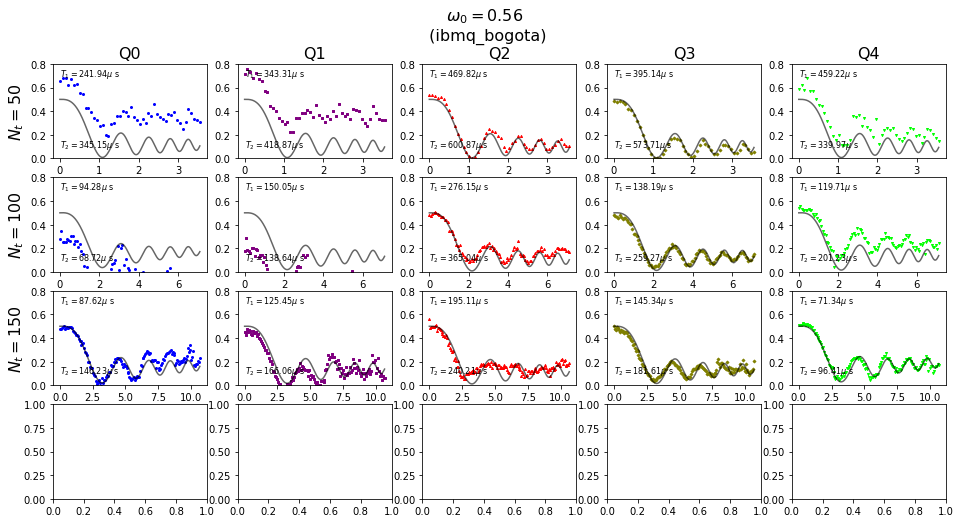

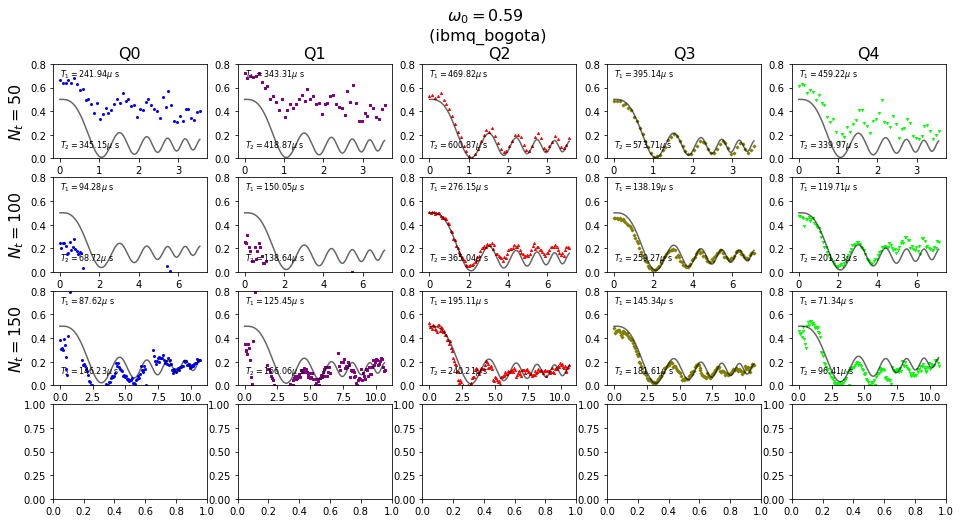

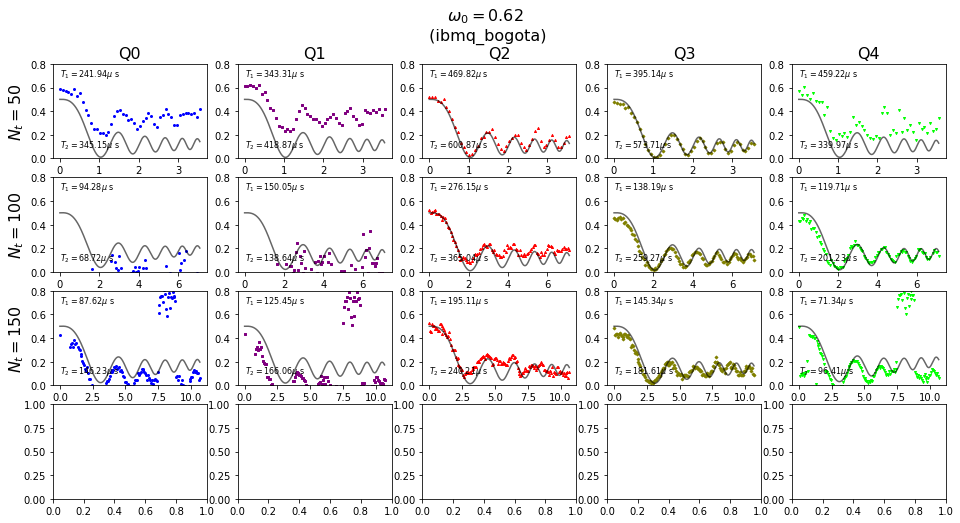

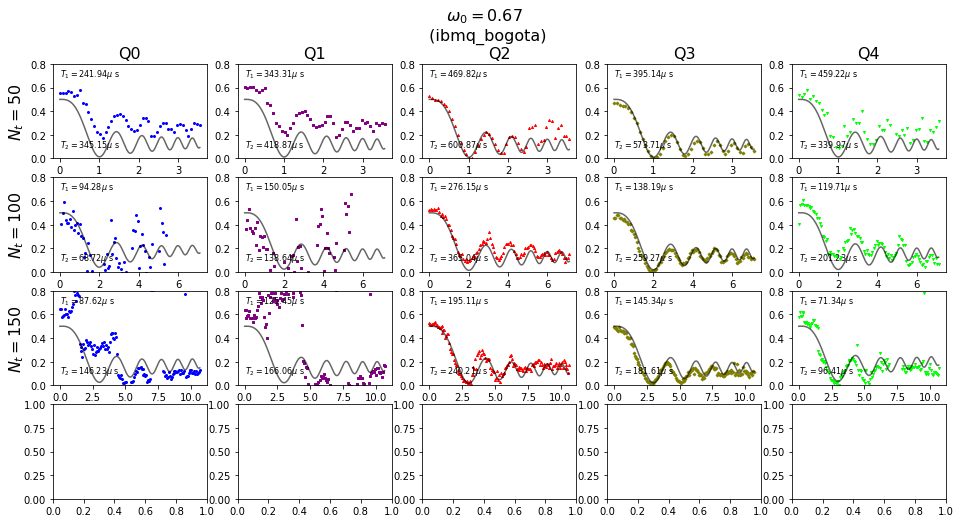

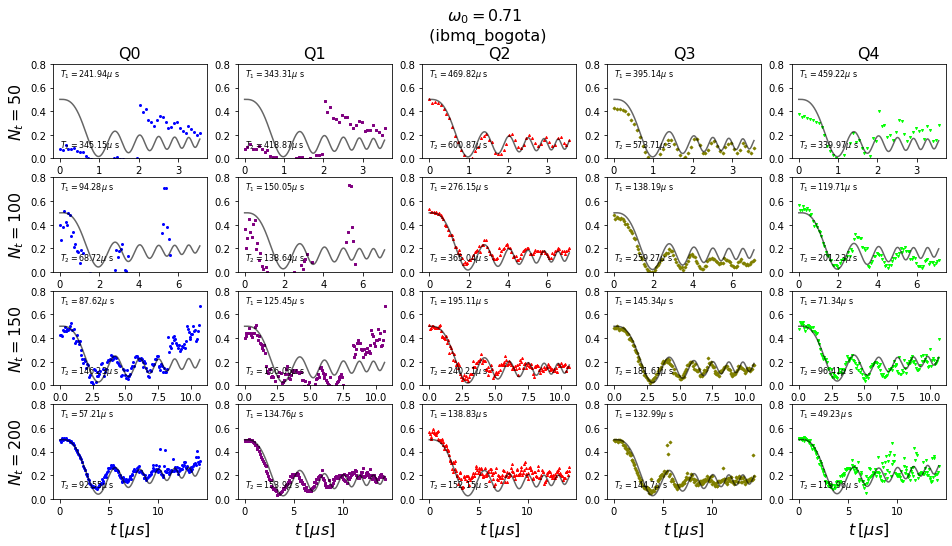

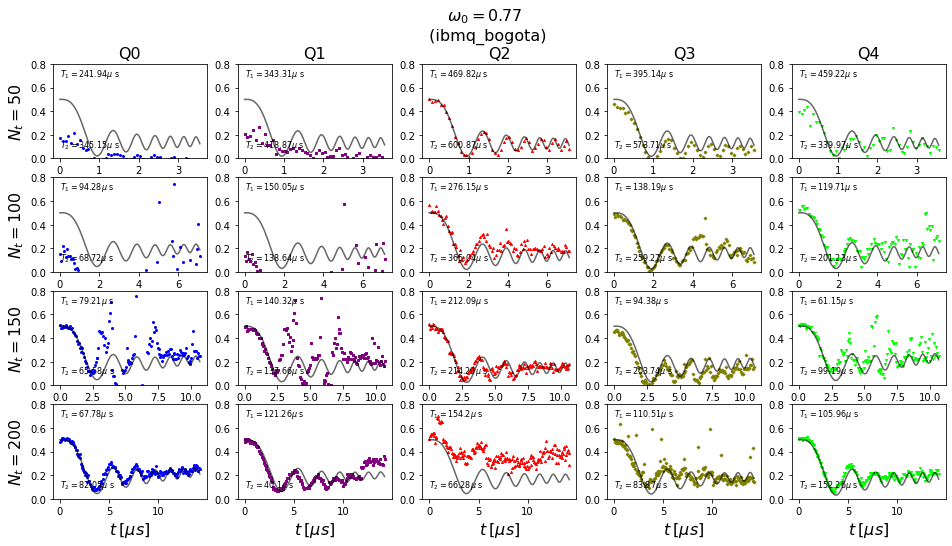

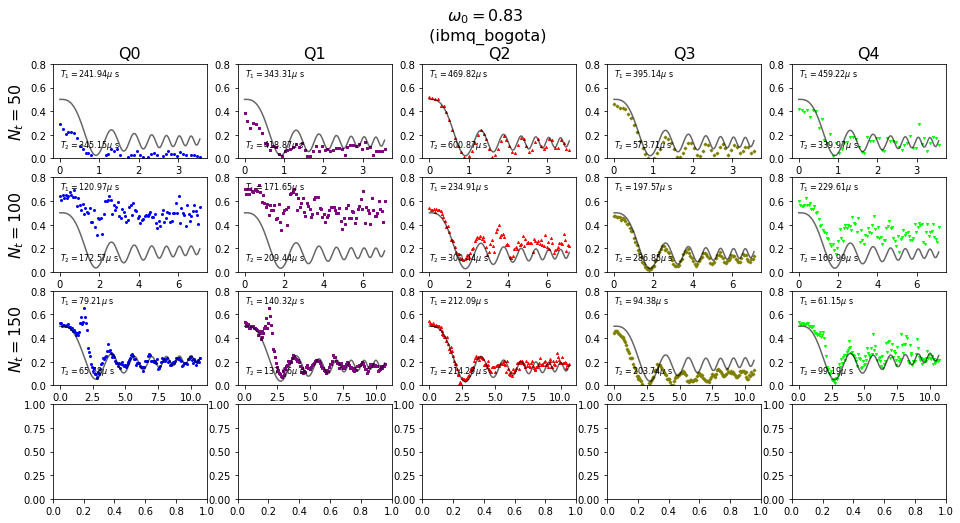

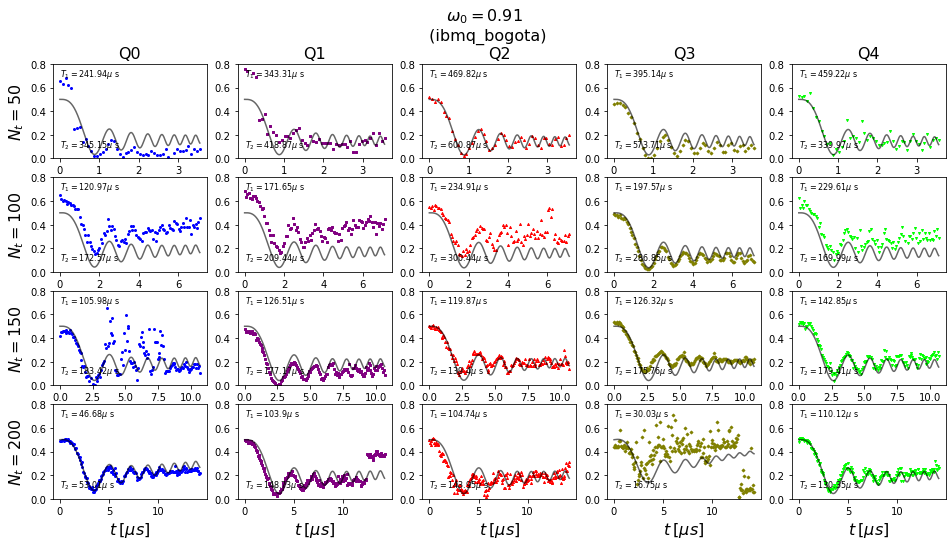

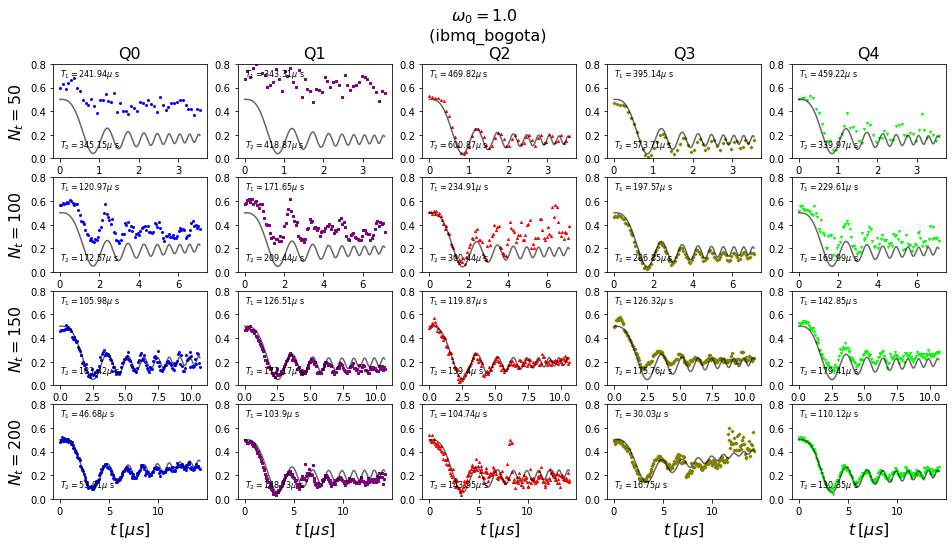

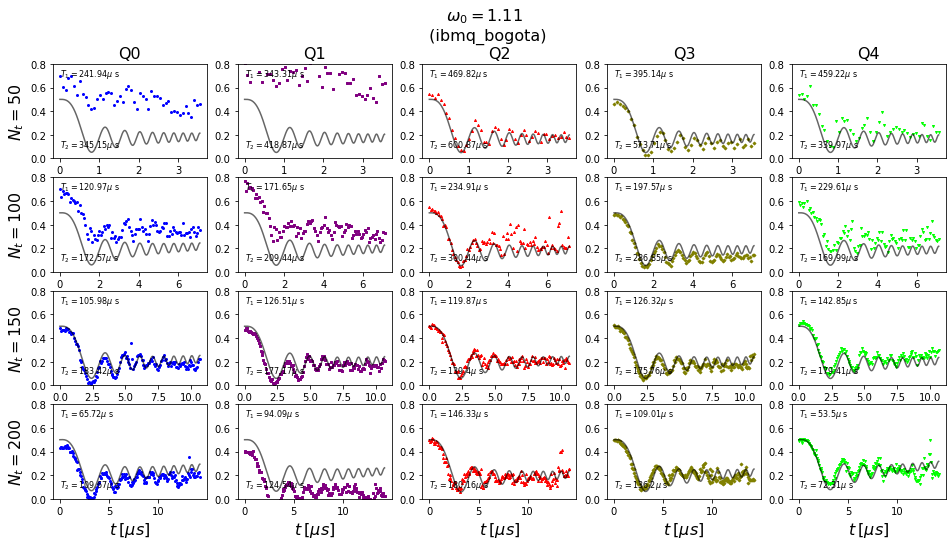

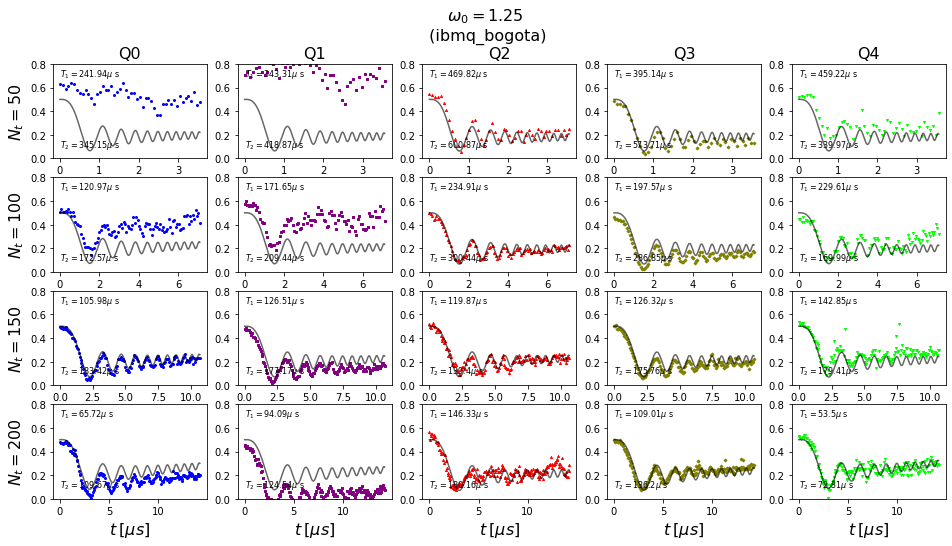

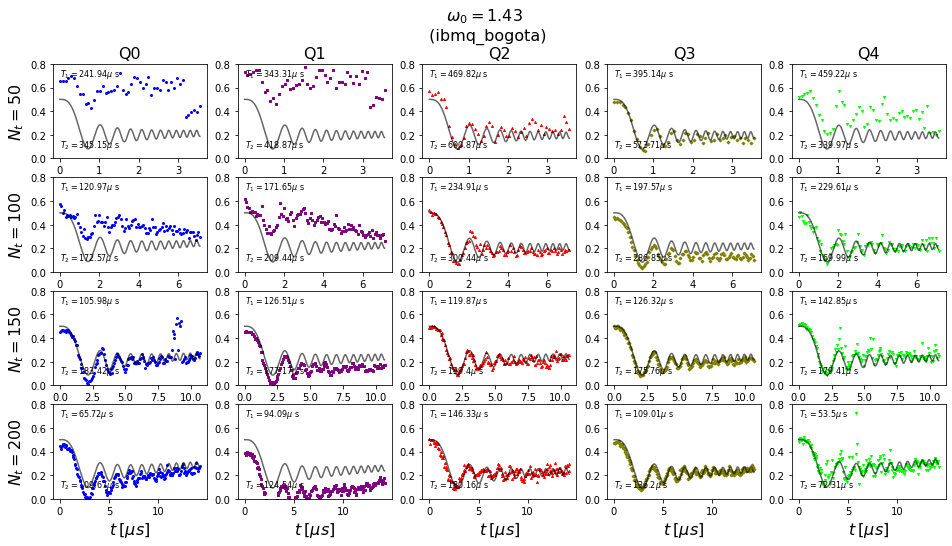

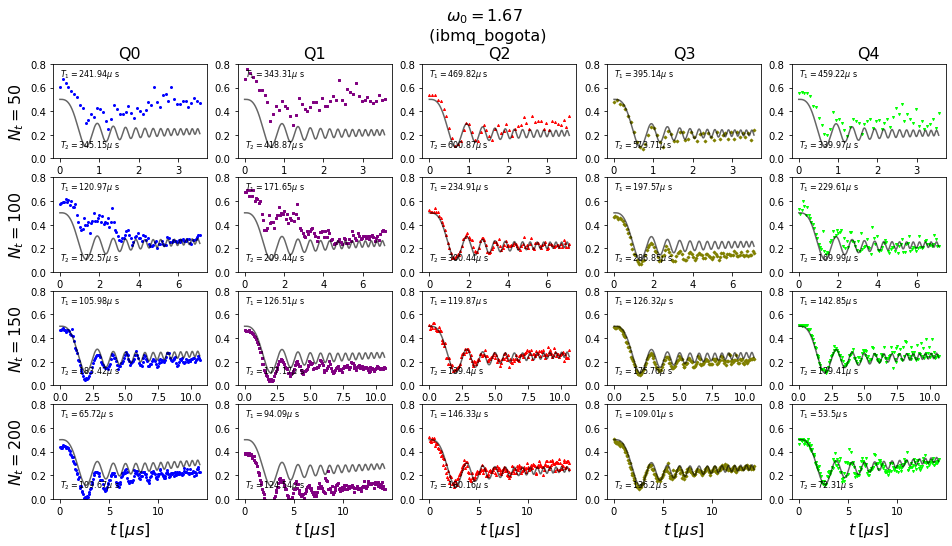

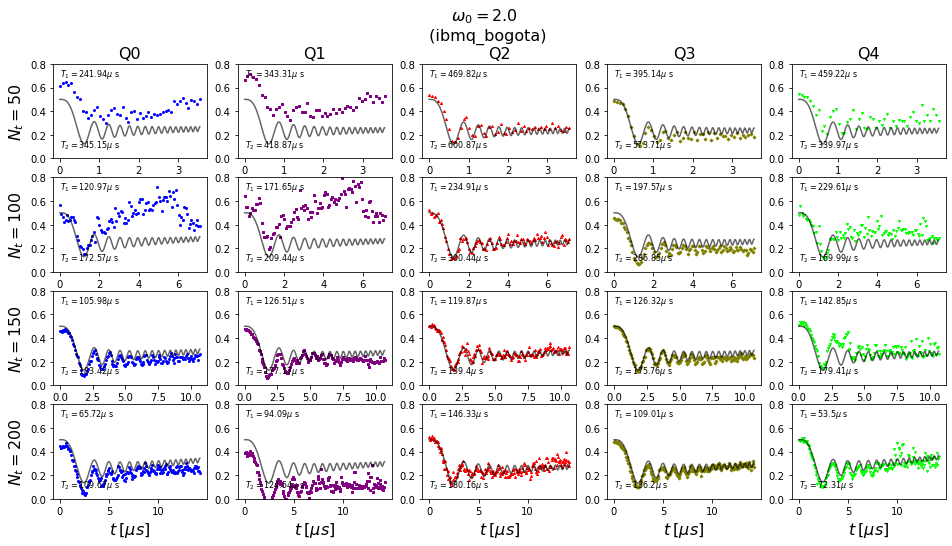

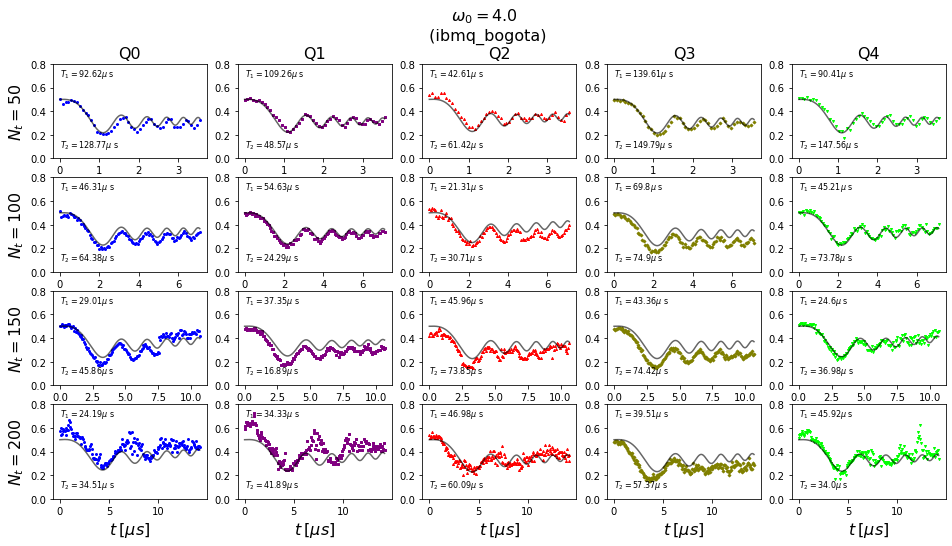

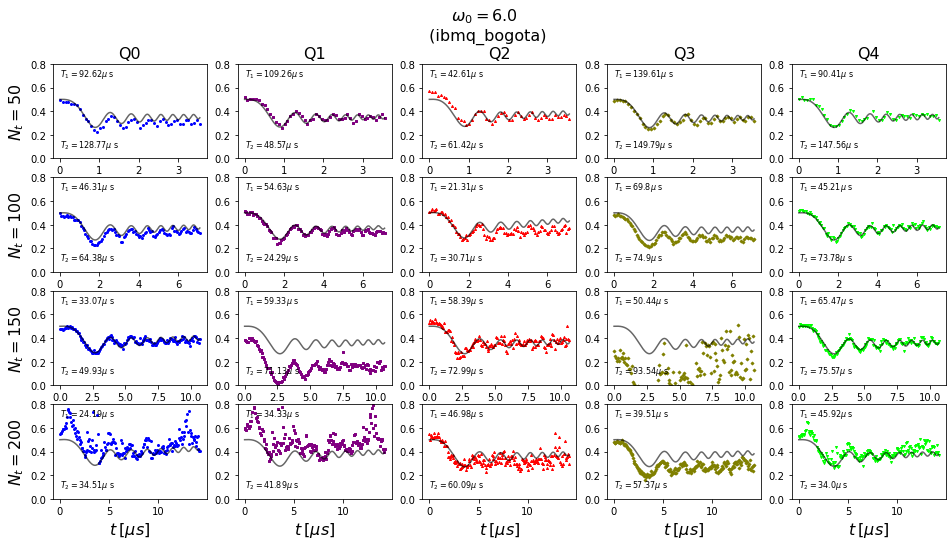

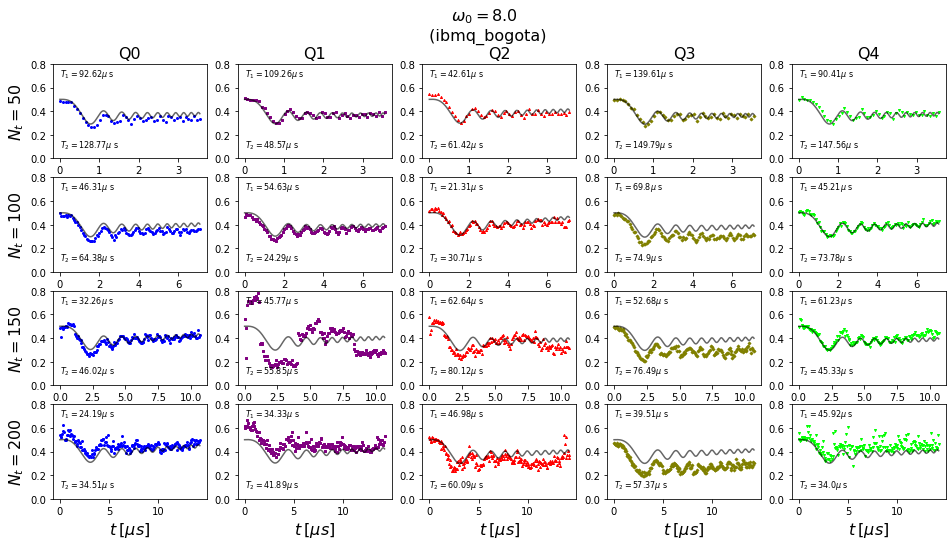

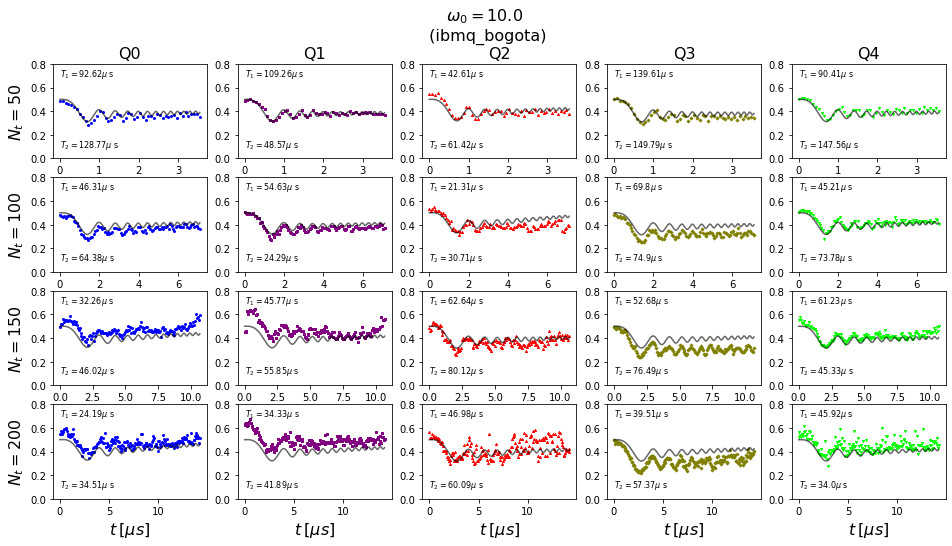

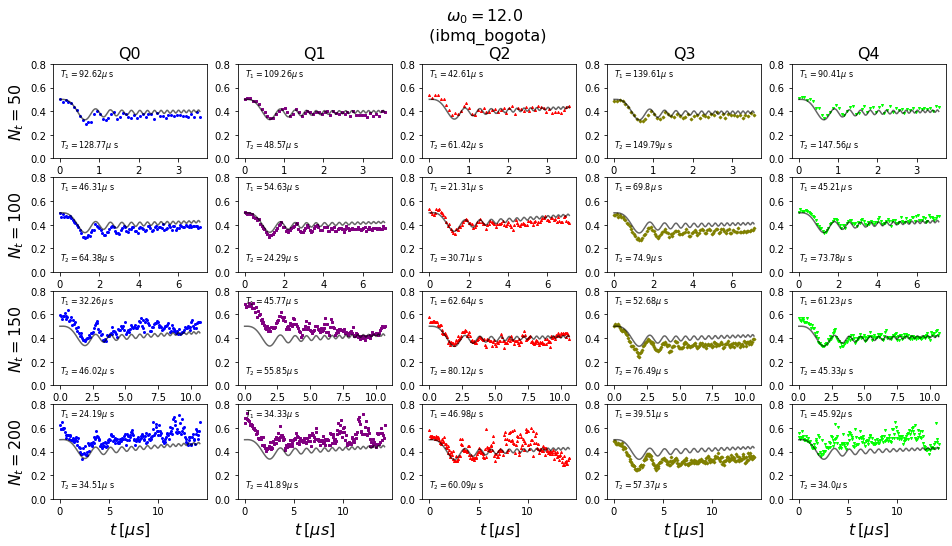

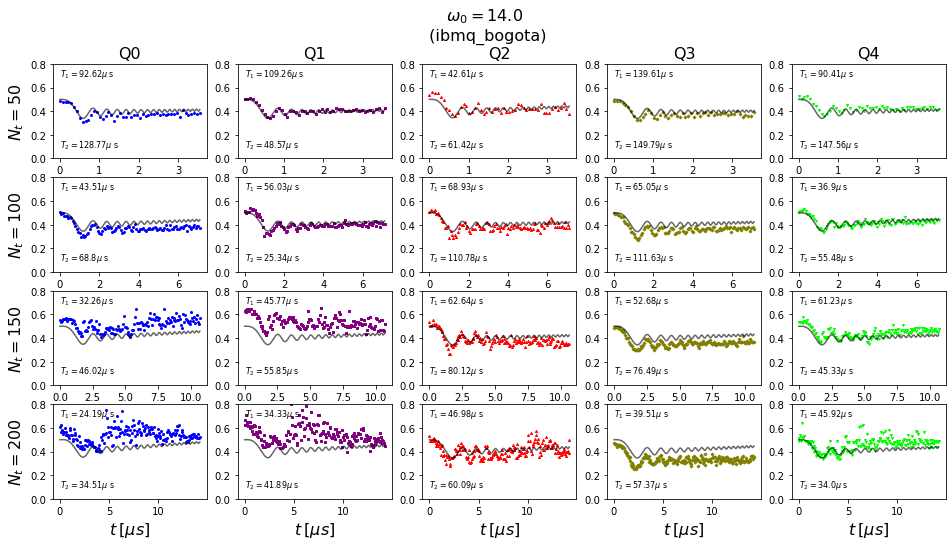

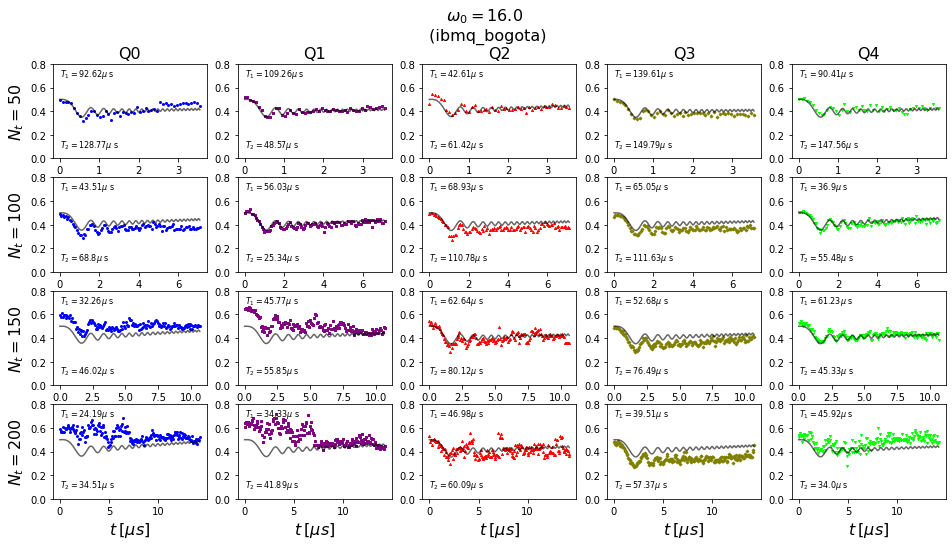

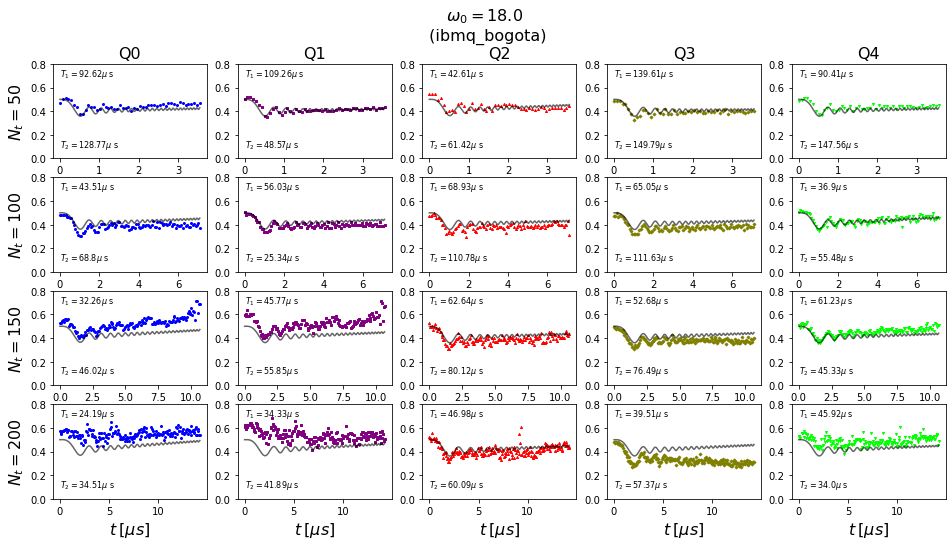

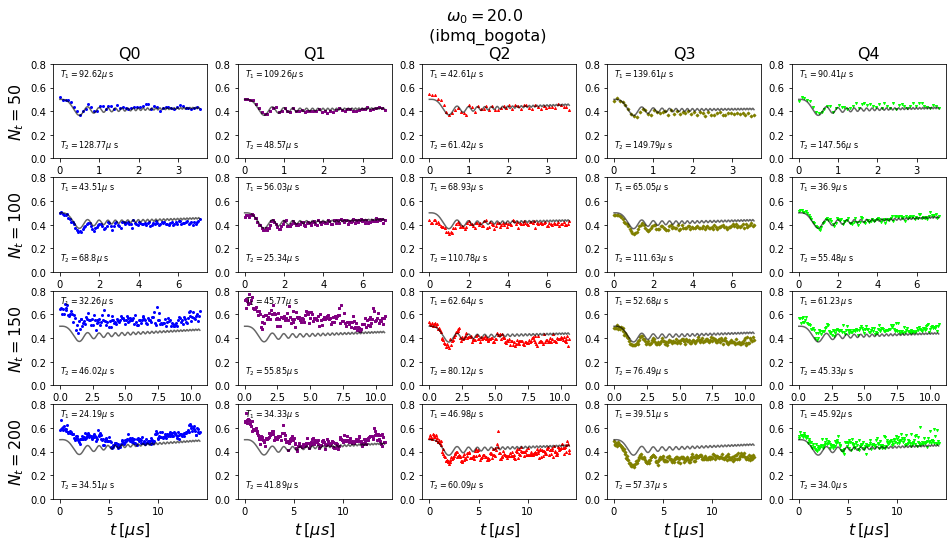

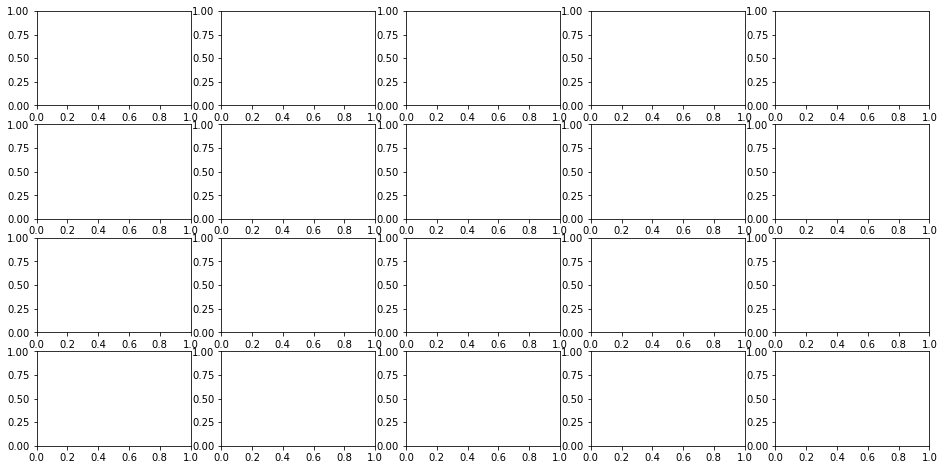

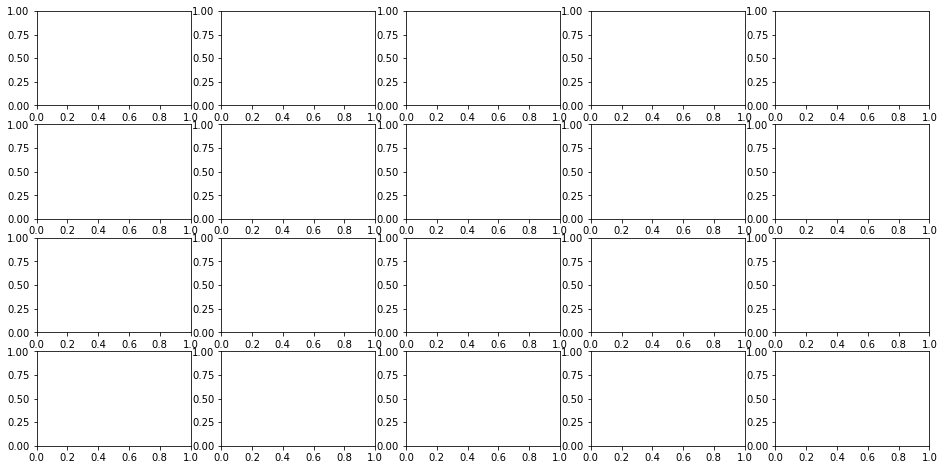

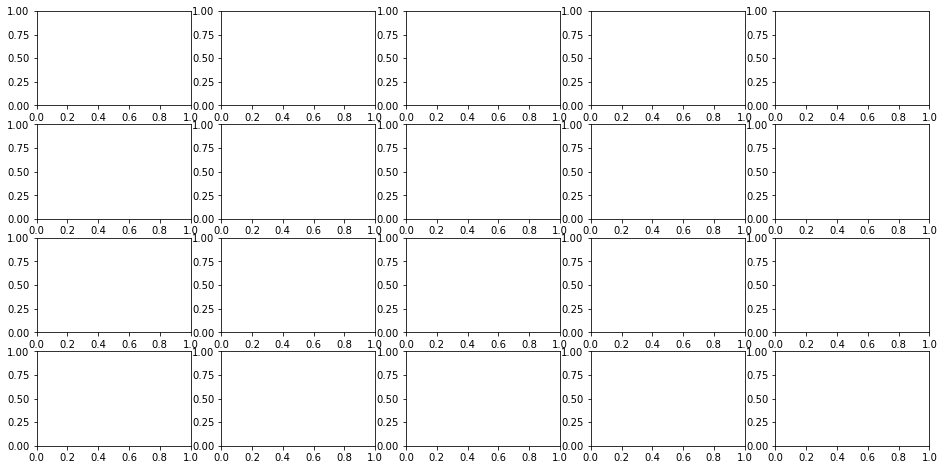

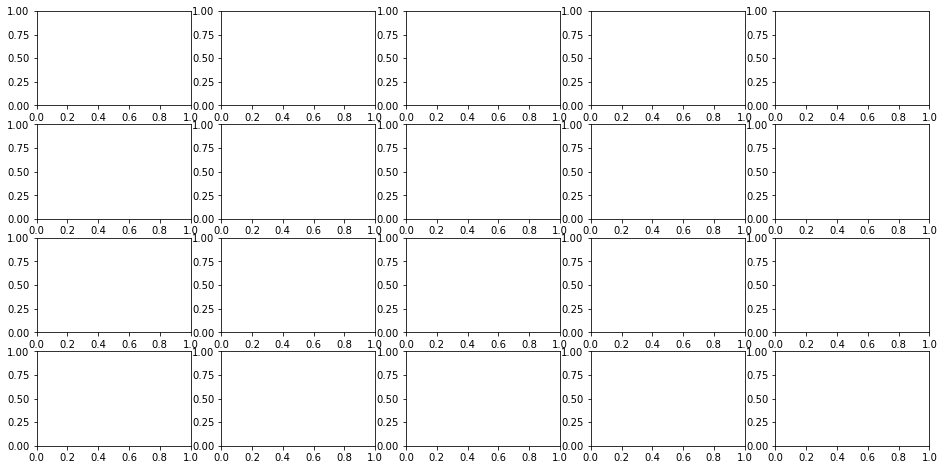

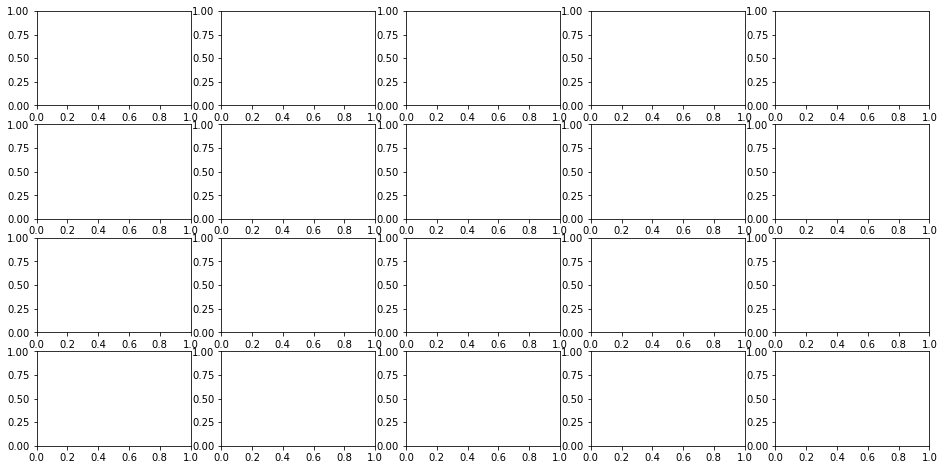

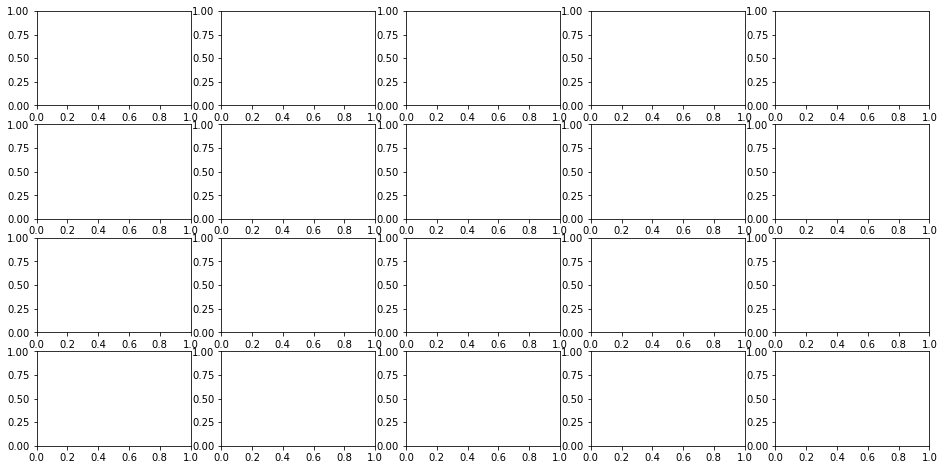

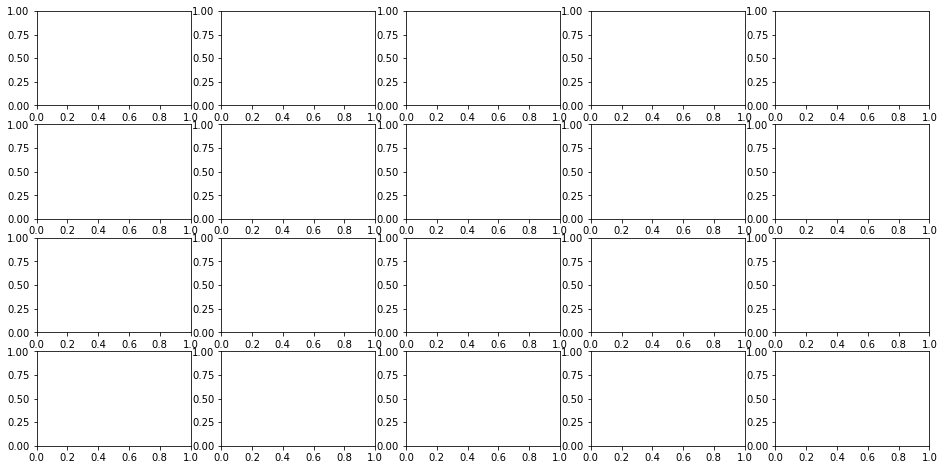

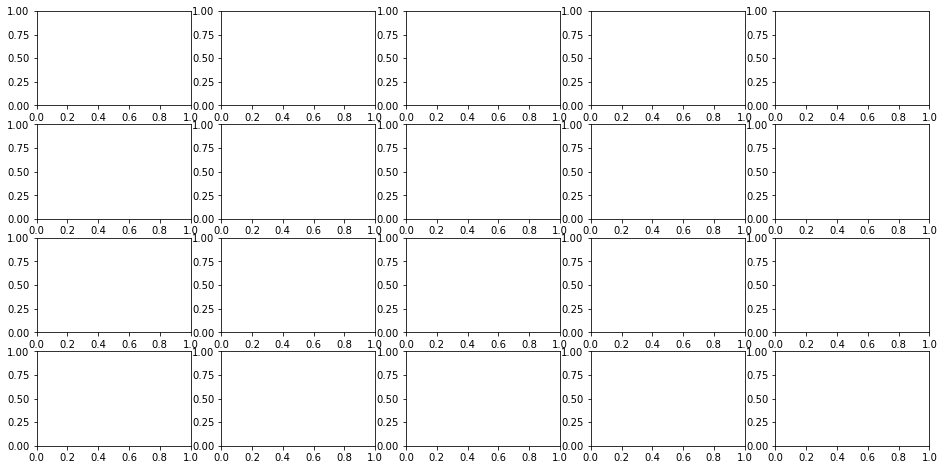

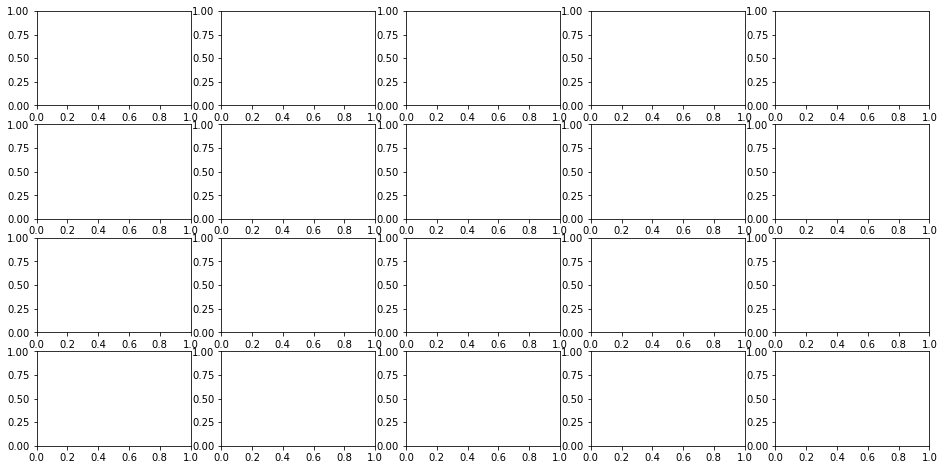

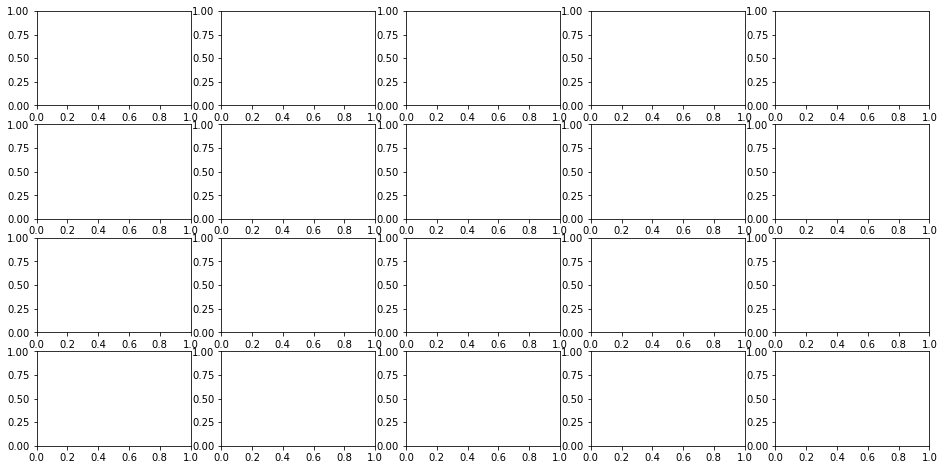

In [23]:
for D in Dlist:
    plotQubitsDeltaSep('bogota', D, calibrated = True)

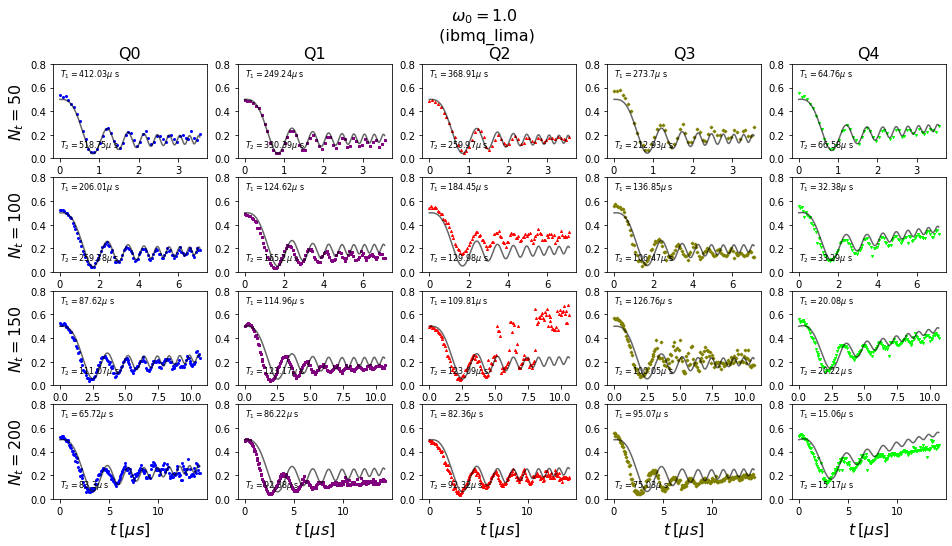

In [24]:
plotQubitsDeltaSep('lima', 1.0, calibrated = True)
plt.savefig('w10_lima.png')

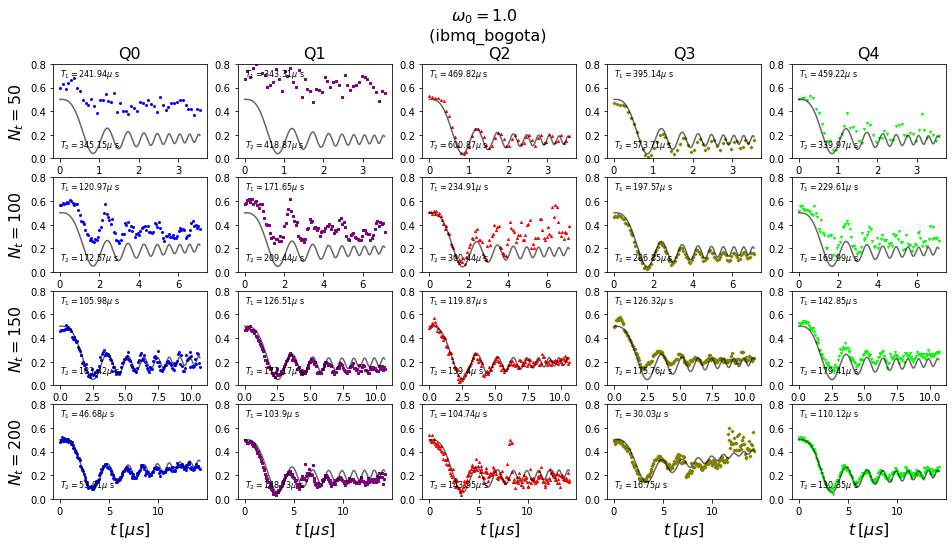

In [25]:
plotQubitsDeltaSep('bogota', 1.0, calibrated = True)
plt.savefig('w10_bogota.png')

# Paper Plot

In [26]:
from matplotlib import gridspec

In [27]:
def darQubitDelta(backend, qbt, D, N, calibrated = True):
    tail = backend+'_SH5000_N'+str(N)+'_w1_D'+str(D)+'_calibrated.dat'
    filename = 'DataCal_13_07_NoReadout/' + tail
    if(tail in os.listdir('DataCal_13_07_NoReadout')):
        Data = file2Matrix(filename)
        t = Data[:,0]
        tR = Data[:, 11] / 1000

        if(calibrated):
            P = Data[:,6:11]
            # fig.suptitle(r'$\Delta = $' +str(D) , fontsize = 30)
        else:
            P = Data[:,1:6]
            # fig.suptitle('Raw Results', fontsize = 30)

        factConv = (t[-1] / N)/0.07111

        times = np.linspace(0, t[-1], 1000)

        [T1vec, T2vec] = getParams(filename)
        T1 = T1vec[qbt] * factConv
        T2 = T2vec[qbt] * factConv
        omega0 = 1
        psi0 = (-1 / np.sqrt(2)) * basis(2, 0) + (1 / np.sqrt(2)) * basis(2, 1) # AntiCrossing
        H0 = (1 / 2) * omega0 * sigmax() 
        H1 = (1 / 2) * D * sigmaz()
        H = [H0, [H1, H1_coeff]]

        result = mesolve(H, psi0, times, [L2(T1, T2), Hrel(T1, T2)], sigmaz())
        Esz = result.expect[0]
        rho00 = (1.0 + Esz) / 2.0
        
        return [rho00, result.times / factConv, P[:, qbt], t / factConv, T1, T2]

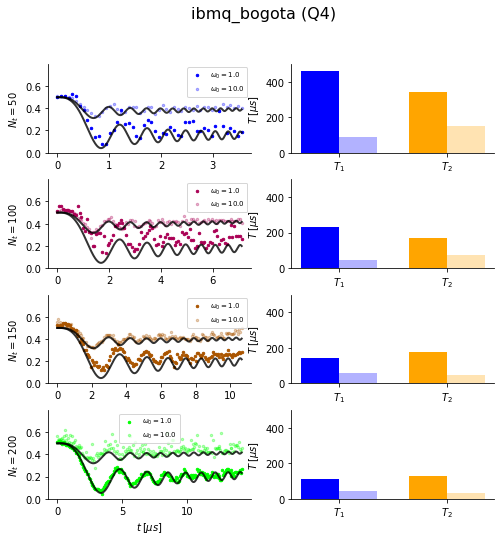

In [30]:
fig, axs = plt.subplots(4, 2, figsize = (8, 8))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0.3)
markerList = np.array(['o', 's', '^', 'D', 'v'])
cmp = cm.get_cmap('brg', 4)

Nlist = [50, 100, 150, 200]
D = [1.0, 10.0]
qbt = 4
backend = 'bogota'
fig.suptitle('ibmq_' + backend + ' (Q'+str(qbt)+')', fontsize = 16)

if backend == 'lima':
    lim = 80
else:
    lim = 500


puntos = []
fits = []
times = []

for i in range(len(Nlist)):
    ans1 = darQubitDelta(backend, qbt, D[0], Nlist[i])
    ans2 = darQubitDelta(backend, qbt, D[1], Nlist[i])
    # log scale for axis Y of the first subplot
    axs[i, 0].plot(ans1[1], ans1[0], c = 'k', alpha = 0.8, linewidth = 2)
    axs[i, 0].scatter(ans1[3], ans1[2], s = 6, color = np.array(cmp(i)), label = r'$\omega_0 =$'+str(D[0]))
    
    axs[i, 0].plot(ans2[1], ans2[0], c = 'k', alpha = 0.8, linewidth = 2)
    axs[i, 0].scatter(ans2[3], ans2[2], s = 6, color = np.array(cmp(i)), alpha = 0.3, label = r'$\omega_0 =$'+str(D[1]))
    
    axs[i, 0].legend(fontsize = 7)
    axs[i, 0].set_ylim((0, 0.8))
    axs[i, 0].set_ylabel(r'$N_t = $'+str(50*(i+1)))
    axs[i, 0].set_yticks(np.arange(0, 0.7, 0.2))
    axs[i, 0].spines['top'].set_visible(False)
    axs[i, 0].spines['right'].set_visible(False)
    
    header = 't [us] P_w0_'+str(D[0])+' P_w0_'+str(D[1])
    puntos = []
    for j in range(Nlist[i]):
        puntos.append([ans1[3][j], ans1[2][j], ans2[2][j]])
        
    fname = 'Plots/'+backend+'_qutip/'+'puntos'+str(Nlist[i])+'.cvs'
    np.savetxt(fname, puntos, delimiter = " ", fmt = '%1.8e', header = header)
            
    fits = []
    for k in range(len(ans2[1])):
        fits.append([ans1[1][k], ans1[0][k], ans2[0][k]])
    
    fname = 'Plots/'+backend+'_qutip/'+'fit'+str(Nlist[i])+'.cvs'
    np.savetxt(fname, fits, delimiter = " ", fmt = '%1.8e', header = header)
    
    labels = [r'$T_1$', r'$T_2$']
    width = 0.35
    Tset1 = [ans1[4], ans1[5]]
    Tset2 = [ans2[4], ans2[5]]
    
    x = np.arange(len(labels))
    
    axs[i, 1].bar(x - width/2, Tset1, width, label=r'$\omega_0=$'+str(D[0]), color = ['b', 'orange'])
    axs[i, 1].bar(x + width/2, Tset2, width, label=r'$\omega_0=$'+str(D[1]), color = ['b', 'orange'], alpha=.3)
    axs[i, 1].set_ylim((0, lim))
    axs[i, 1].set_ylabel(r'$T\>[\mu s]$')
    axs[i, 1].spines['top'].set_visible(False)
    axs[i, 1].spines['right'].set_visible(False)
    axs[i, 1].set_xticks(x)
    axs[i, 1].set_xticklabels(labels)
    
    times.append([Nlist[i], Tset1[0], Tset1[1], Tset2[0], Tset2[1]])

fname = 'Plots/'+backend+'_qutip/'+backend+'_tiempos.cvs'
header = 'N T1_w0_'+str(D[0])+' T2_w0_'+str(D[0])+' T1_w0_'+str(D[1])+' T2_w0_'+str(D[1])
np.savetxt(fname, times, delimiter = " ", fmt = '%1.8e', header = header)

axs[3, 0].set_xlabel(r'$t\>[\mu s]$')

# remove vertical gap between subplots
plt.savefig('Plots/'+backend+'_qutip/'+backend+'_qutipFit.png', dpi = 500)
plt.show()

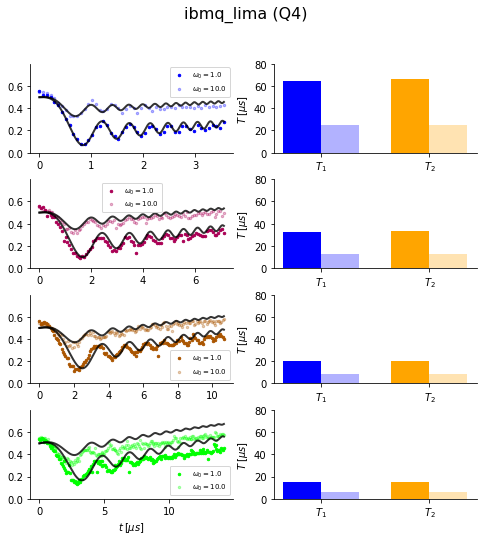

In [31]:
fig, axs = plt.subplots(4, 2, figsize = (8, 8))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0.3)
markerList = np.array(['o', 's', '^', 'D', 'v'])
cmp = cm.get_cmap('brg', 4)

Nlist = [50, 100, 150, 200]
D = [1.0, 10.0]
qbt = 4
backend = 'lima'
fig.suptitle('ibmq_' + backend + ' (Q'+str(qbt)+')', fontsize = 16)

if backend == 'lima':
    lim = 80
else:
    lim = 500


puntos = []
fits = []
times = []

for i in range(len(Nlist)):
    ans1 = darQubitDelta(backend, qbt, D[0], Nlist[i])
    ans2 = darQubitDelta(backend, qbt, D[1], Nlist[i])
    # log scale for axis Y of the first subplot
    axs[i, 0].plot(ans1[1], ans1[0], c = 'k', alpha = 0.8, linewidth = 2)
    axs[i, 0].scatter(ans1[3], ans1[2], s = 6, color = np.array(cmp(i)), label = r'$\omega_0 =$'+str(D[0]))
    
    axs[i, 0].plot(ans2[1], ans2[0], c = 'k', alpha = 0.8, linewidth = 2)
    axs[i, 0].scatter(ans2[3], ans2[2], s = 6, color = np.array(cmp(i)), alpha = 0.3, label = r'$\omega_0 =$'+str(D[1]))
    
    axs[i, 0].legend(fontsize = 7)
    axs[i, 0].set_ylim((0, 0.8))
    # axs[i, 0].set_ylabel(r'$N_t = $'+str(50*(i+1)))
    axs[i, 0].set_yticks(np.arange(0, 0.7, 0.2))
    axs[i, 0].spines['top'].set_visible(False)
    axs[i, 0].spines['right'].set_visible(False)
    
    header = 't [us] P_w0_'+str(D[0])+' P_w0_'+str(D[1])
    puntos = []
    for j in range(Nlist[i]):
        puntos.append([ans1[3][j], ans1[2][j], ans2[2][j]])
        
    fname = 'Plots/'+backend+'_qutip/'+'puntos'+str(Nlist[i])+'.cvs'
    np.savetxt(fname, puntos, delimiter = " ", fmt = '%1.8e', header = header)
            
    fits = []
    for k in range(len(ans2[1])):
        fits.append([ans1[1][k], ans1[0][k], ans2[0][k]])
    
    fname = 'Plots/'+backend+'_qutip/'+'fit'+str(Nlist[i])+'.cvs'
    np.savetxt(fname, fits, delimiter = " ", fmt = '%1.8e', header = header)
    
    labels = [r'$T_1$', r'$T_2$']
    width = 0.35
    Tset1 = [ans1[4], ans1[5]]
    Tset2 = [ans2[4], ans2[5]]
    
    x = np.arange(len(labels))
    
    axs[i, 1].bar(x - width/2, Tset1, width, label=r'$\omega_0=$'+str(D[0]), color = ['b', 'orange'])
    axs[i, 1].bar(x + width/2, Tset2, width, label=r'$\omega_0=$'+str(D[1]), color = ['b', 'orange'], alpha=.3)
    axs[i, 1].set_ylim((0, lim))
    axs[i, 1].set_ylabel(r'$T\>[\mu s]$')
    axs[i, 1].spines['top'].set_visible(False)
    axs[i, 1].spines['right'].set_visible(False)
    axs[i, 1].set_xticks(x)
    axs[i, 1].set_xticklabels(labels)
    
    times.append([Nlist[i], Tset1[0], Tset1[1], Tset2[0], Tset2[1]])

fname = 'Plots/'+backend+'_qutip/'+backend+'_tiempos.cvs'
header = 'N T1_w0_'+str(D[0])+' T2_w0_'+str(D[0])+' T1_w0_'+str(D[1])+' T2_w0_'+str(D[1])
np.savetxt(fname, times, delimiter = " ", fmt = '%1.8e', header = header)

axs[3, 0].set_xlabel(r'$t\>[\mu s]$')

# remove vertical gap between subplots
plt.savefig('Plots/'+backend+'_qutip/'+backend+'_qutipFit.png', dpi = 500)
plt.show()